## PROJECT-5: Анализ поведения пользователей в приложении и каналов их привлечения

## Цель: 

Компании-сервису по доставке продуктов на дом необходимо проанализировать поведение пользователей в приложении, а также оценить эффективность каналов их привлечения.

# Задачи:

1. Обработать данные инструментами Python 
2. Проанализировать распределение трафика в приложении по событиям/ по группам пользователей/ по каналам привлечения
3. Построить воронку продаж
4. Сравнить CR
5. Сравнить ROMI платных каналов привлечения
2. Провести когортный анализ по неделе первого посещения/первой покупки

In [1]:
# импортируем необходимые библиотеки для обработки данных и создания визуализаций
import pandas as pd
import numpy as np
import datetime as dt

import plotly
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# загружаем данный в DataFrame и приводим данные к нужному типу
data_df = pd.read_csv('SF_case_data.csv', low_memory=False)
data_df['date'] = pd.to_datetime(data_df['date'])

In [2]:
data_df.head()

date      event  purchase_sum  os_name  device_id  gender  \
0 2020-01-01  app_start           NaN  android     669460  female   
1 2020-01-01  app_start           NaN      ios     833621    male   
2 2020-01-01  app_start           NaN  android    1579237    male   
3 2020-01-01  app_start           NaN  android    1737182  female   
4 2020-01-01  app_start           NaN      ios    4029024  female   

               city    utm_source  
0            Moscow             -  
1            Moscow        vk_ads  
2  Saint-Petersburg       referal  
3            Moscow  facebook_ads  
4            Moscow  facebook_ads

## Анализ воронки продаж и эффективности каналов привлечения

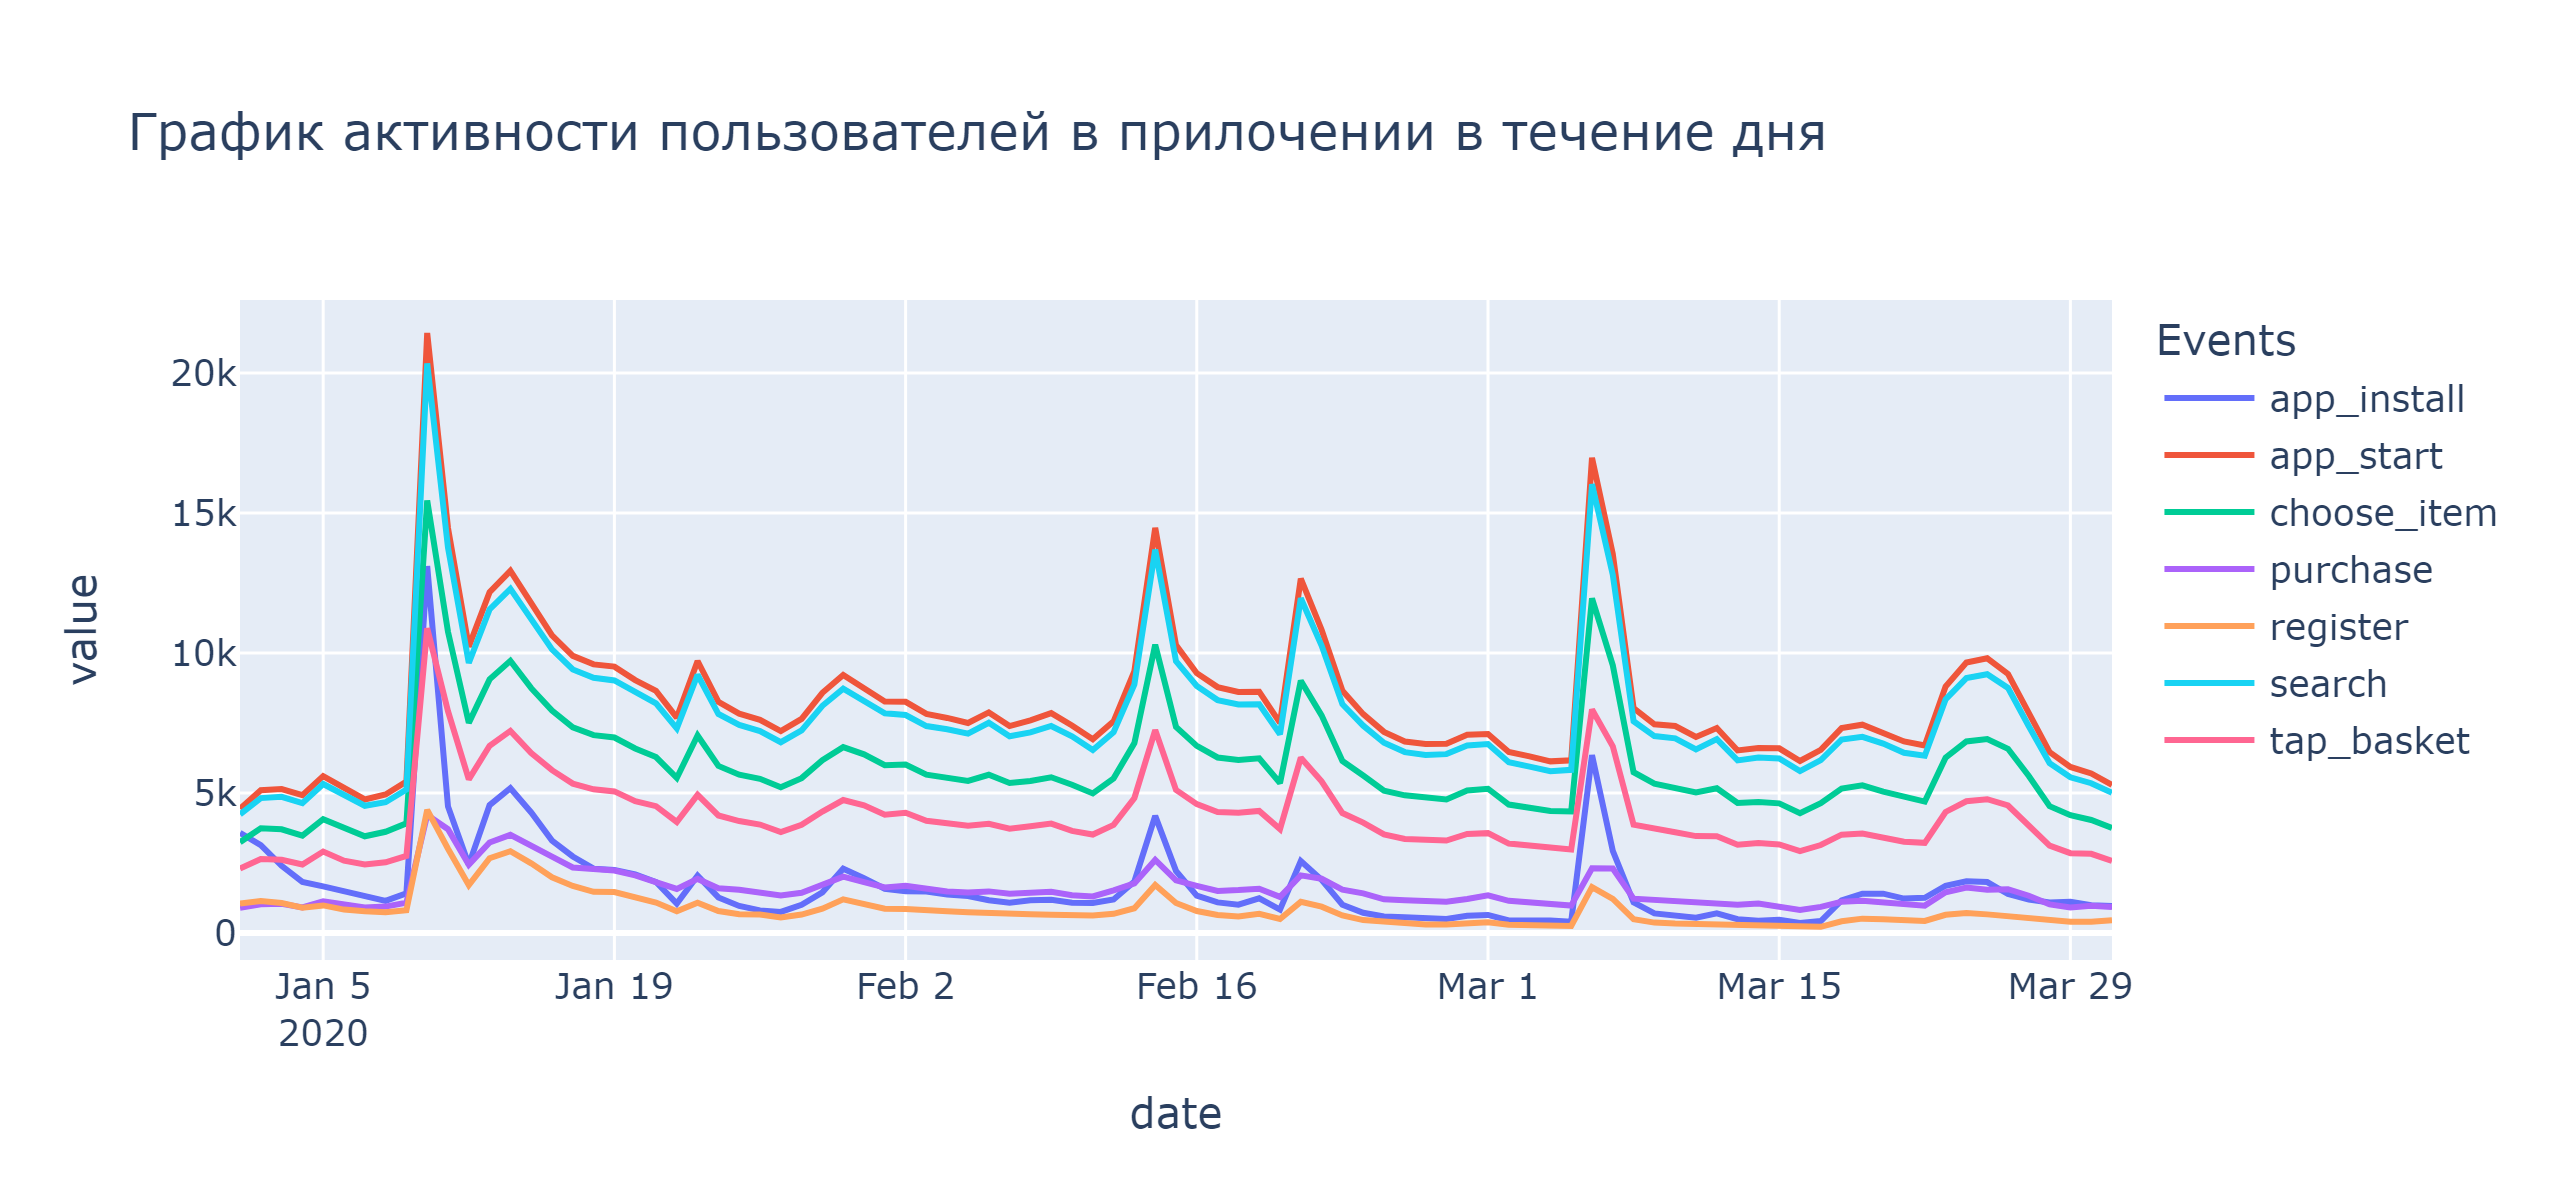

In [3]:
# группируем данные по дате и типу события и с помощью метода size выводим количество событий по дням
groupped_events = data_df.groupby(
    ['date', 'event']
).size()
# с помощью метода unstack формируем DataFrame из полученных данных
daily_active = groupped_events.unstack(level='event')
daily_active.columns.name = 'Events'

# создаем график с событиями по дням
fig = px.line(
    data_frame=daily_active,
    height=500,
    width=1000,
    title='График активности пользователей в прилочении в течение дня'
)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

График событий по дням показывает, что трафик открытия приложения самый высокий среди событий. Самый низкий трафик на этапах: установка приложения, регистрация, покупка.

Предварительно, можно сделать следующие промежуточные выводы: 

1. Пик трафика открытия приложений пришелся на период окончания НГ праздников, а также в преддверии 14, 23 февраля и 8 марта, скорее всего это результат маркетинговых акций; 
2. Малое число зарегистрированных пользователей, говорит о том, что этап регистрации отпугивает пользователей, поэтому стоит упростить процесс регистрации пользователей, что может стать точкой роста.

Рассмотрим как распределяется трафик среди пользователей, которые открыли приложении в день его установки, и остальных пользователей.

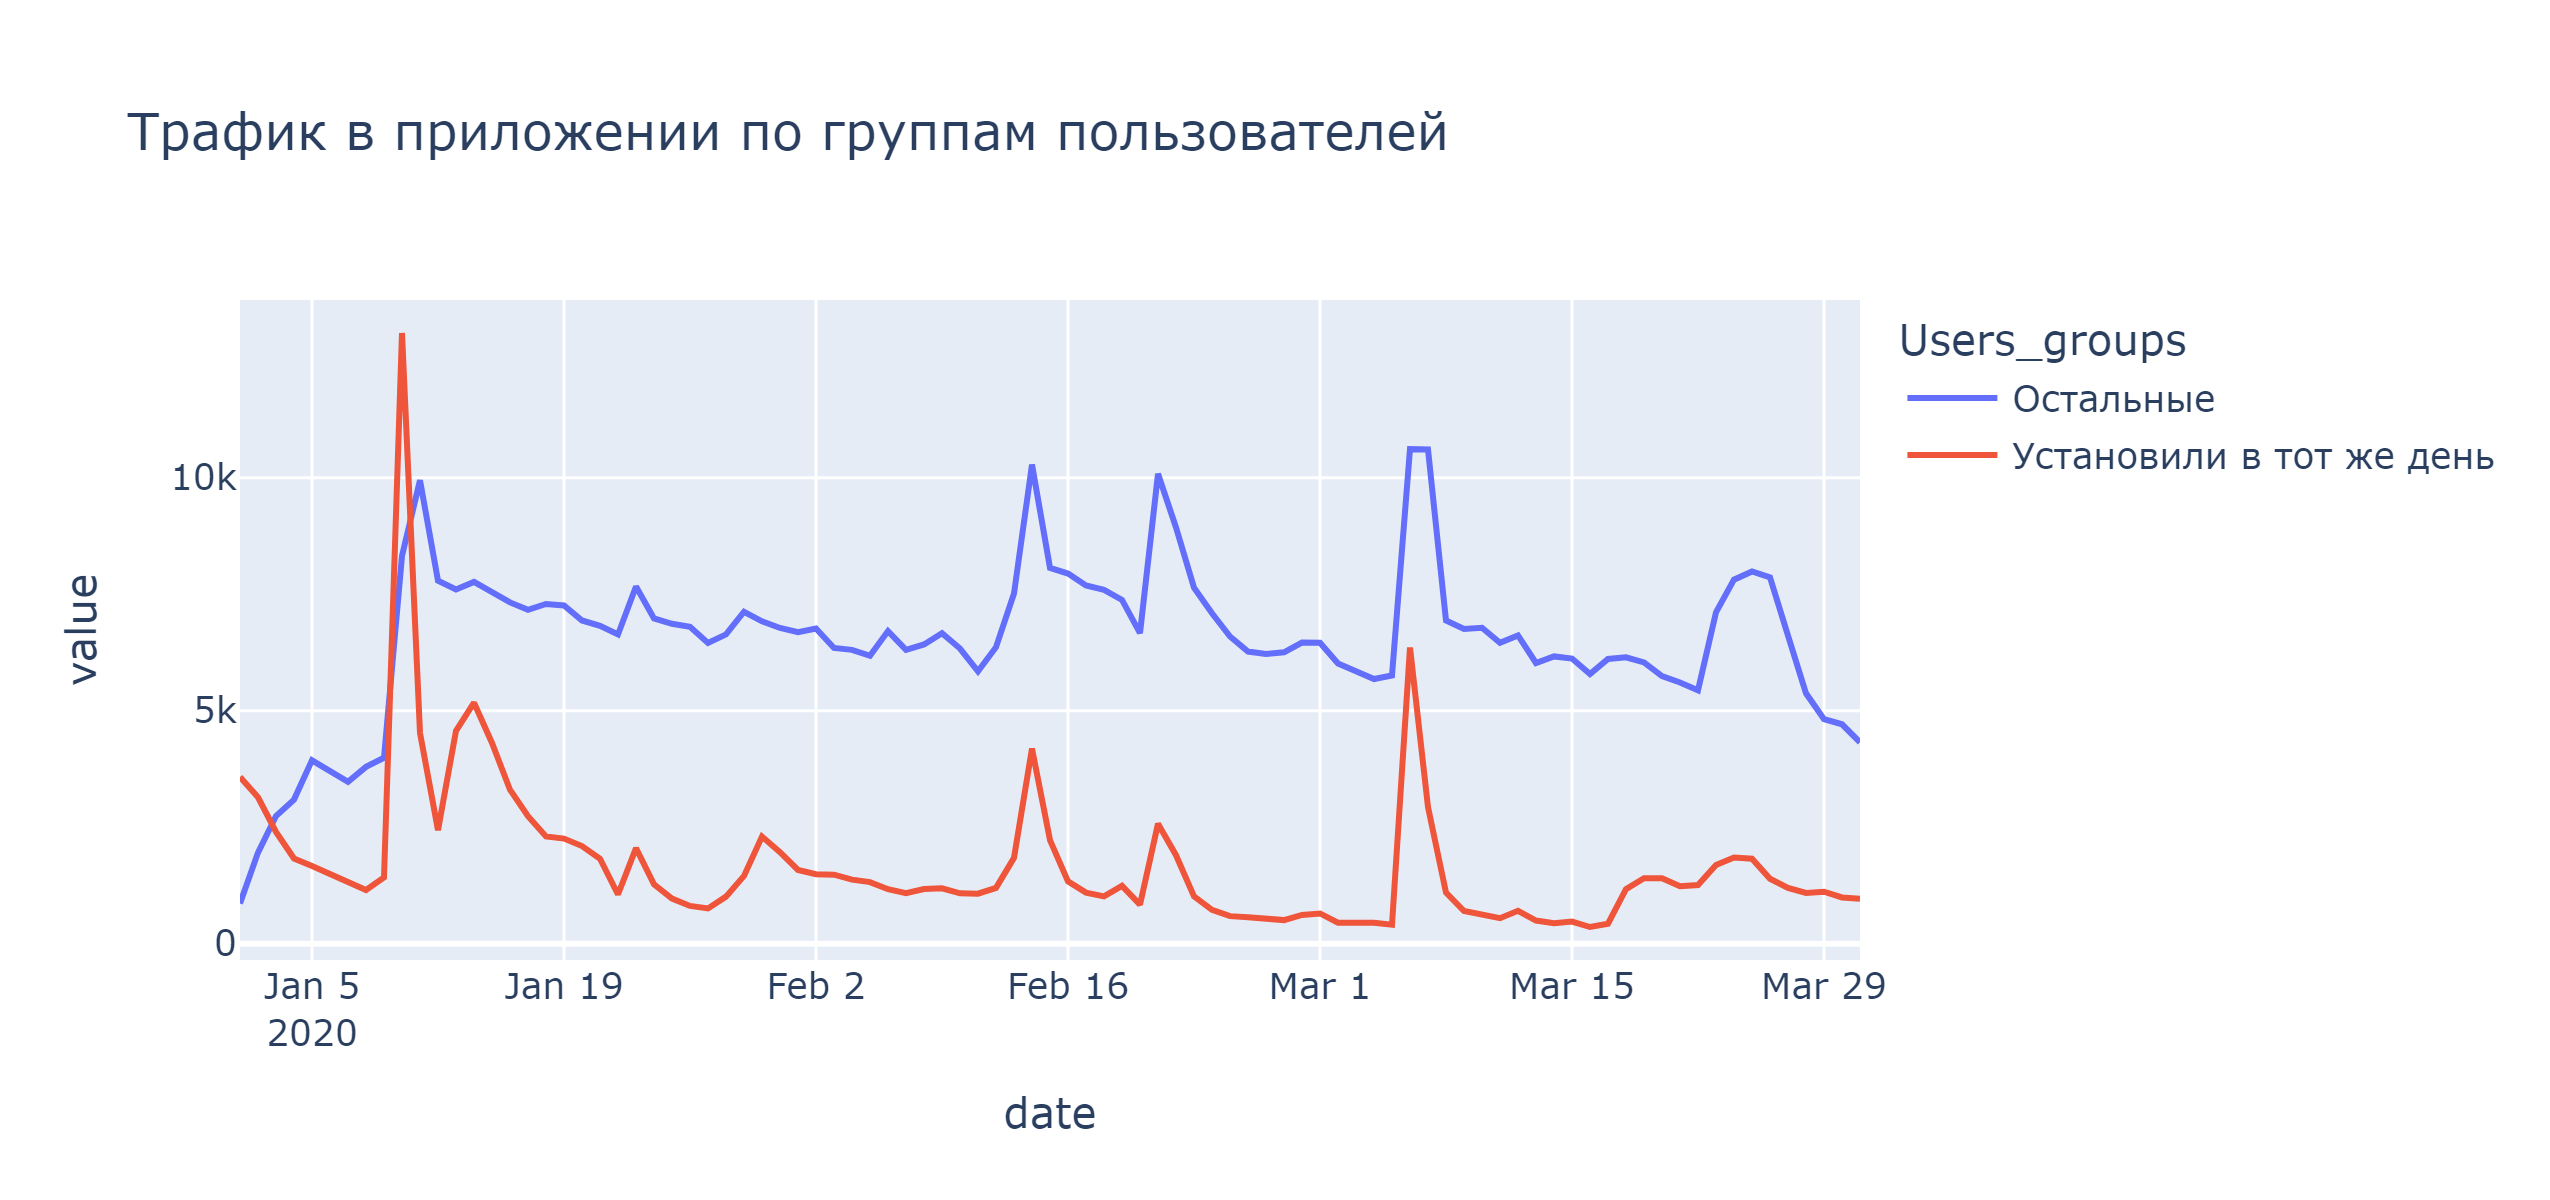

In [4]:
# формируем DataFrame с датами усановки приложения пользователями
app_install_df = data_df[data_df['event'] == 'app_install'][['date', 'device_id']]
app_install_df.rename(
    columns={'date': 'app_install_date'}, 
    inplace=True
)
# добавляем в основной DataFrame столбец с датой установки приложения
data_df = data_df.merge(
    app_install_df, 
    how='left', 
    on='device_id'
)

# создаем функцию, которая принимаем дату события и возвращает статус 
# "Установили в тот же день", если событие совпадает с датой установки приложения,
# и статус "Остальные", если не совпадает
def get_user_group(date, install_date):
    if date == install_date:
        return 'Установили в тот же день'
    return 'Остальные'

# применяем функцию к основному DataFrame
data_df['user_group'] = data_df.apply(
    lambda x: get_user_group(date = x['date'], 
                             install_date = x['app_install_date']),
                            axis=1
)

# выводим данные о количестве открытий приложения по дням и по группам пользователей
traffic_data = data_df[data_df['event'] == 'app_start'].groupby(
    ['date', 'user_group']
).size()
# формируем DataFrame из полученных данных
traffic_table = traffic_data.unstack(level='user_group')
traffic_table.columns.name = 'Users_groups'

# создаем график с распределением трафика от открытия приложения по группам пользователей
fig = px.line(
    data_frame=traffic_table,
    height=500,
    width=1000,
    title='Трафик в приложении по группам пользователей'
)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

In [5]:
cond_1 = data_df['event'] == 'app_start'
cond_2 = data_df['date'] == '2020-02-14'
cond_3 = data_df['user_group'] == 'Остальные'

print('Доля трафика 14 марта на пользователей, \
у которых приложение уже было установлено: {:.2%}'.format(
    data_df[cond_1 & cond_2 & cond_3]['device_id'].count() / data_df[cond_1 & cond_2]['device_id'].count()))


Доля трафика 14 марта на пользователей, у которых приложение уже было установлено: 71.06%


Большая часть трафика приходится на пользователей, которые уже пользуются приложение, т.е. установили его ранее, что говорит о том что "старые" пользователи более активны, чем "новые". Это говорит о лояльности пользователей. 
График трафика от пользователей, которые установили и открыли приложение в тот же день, скачкообразный. Пики приходятся в периоды праздников. Возможно это подтверждает, что эти пользователи привлечены маркетинговыми акциями.
Однако, трафик обеих групп снижается к концу Q1.

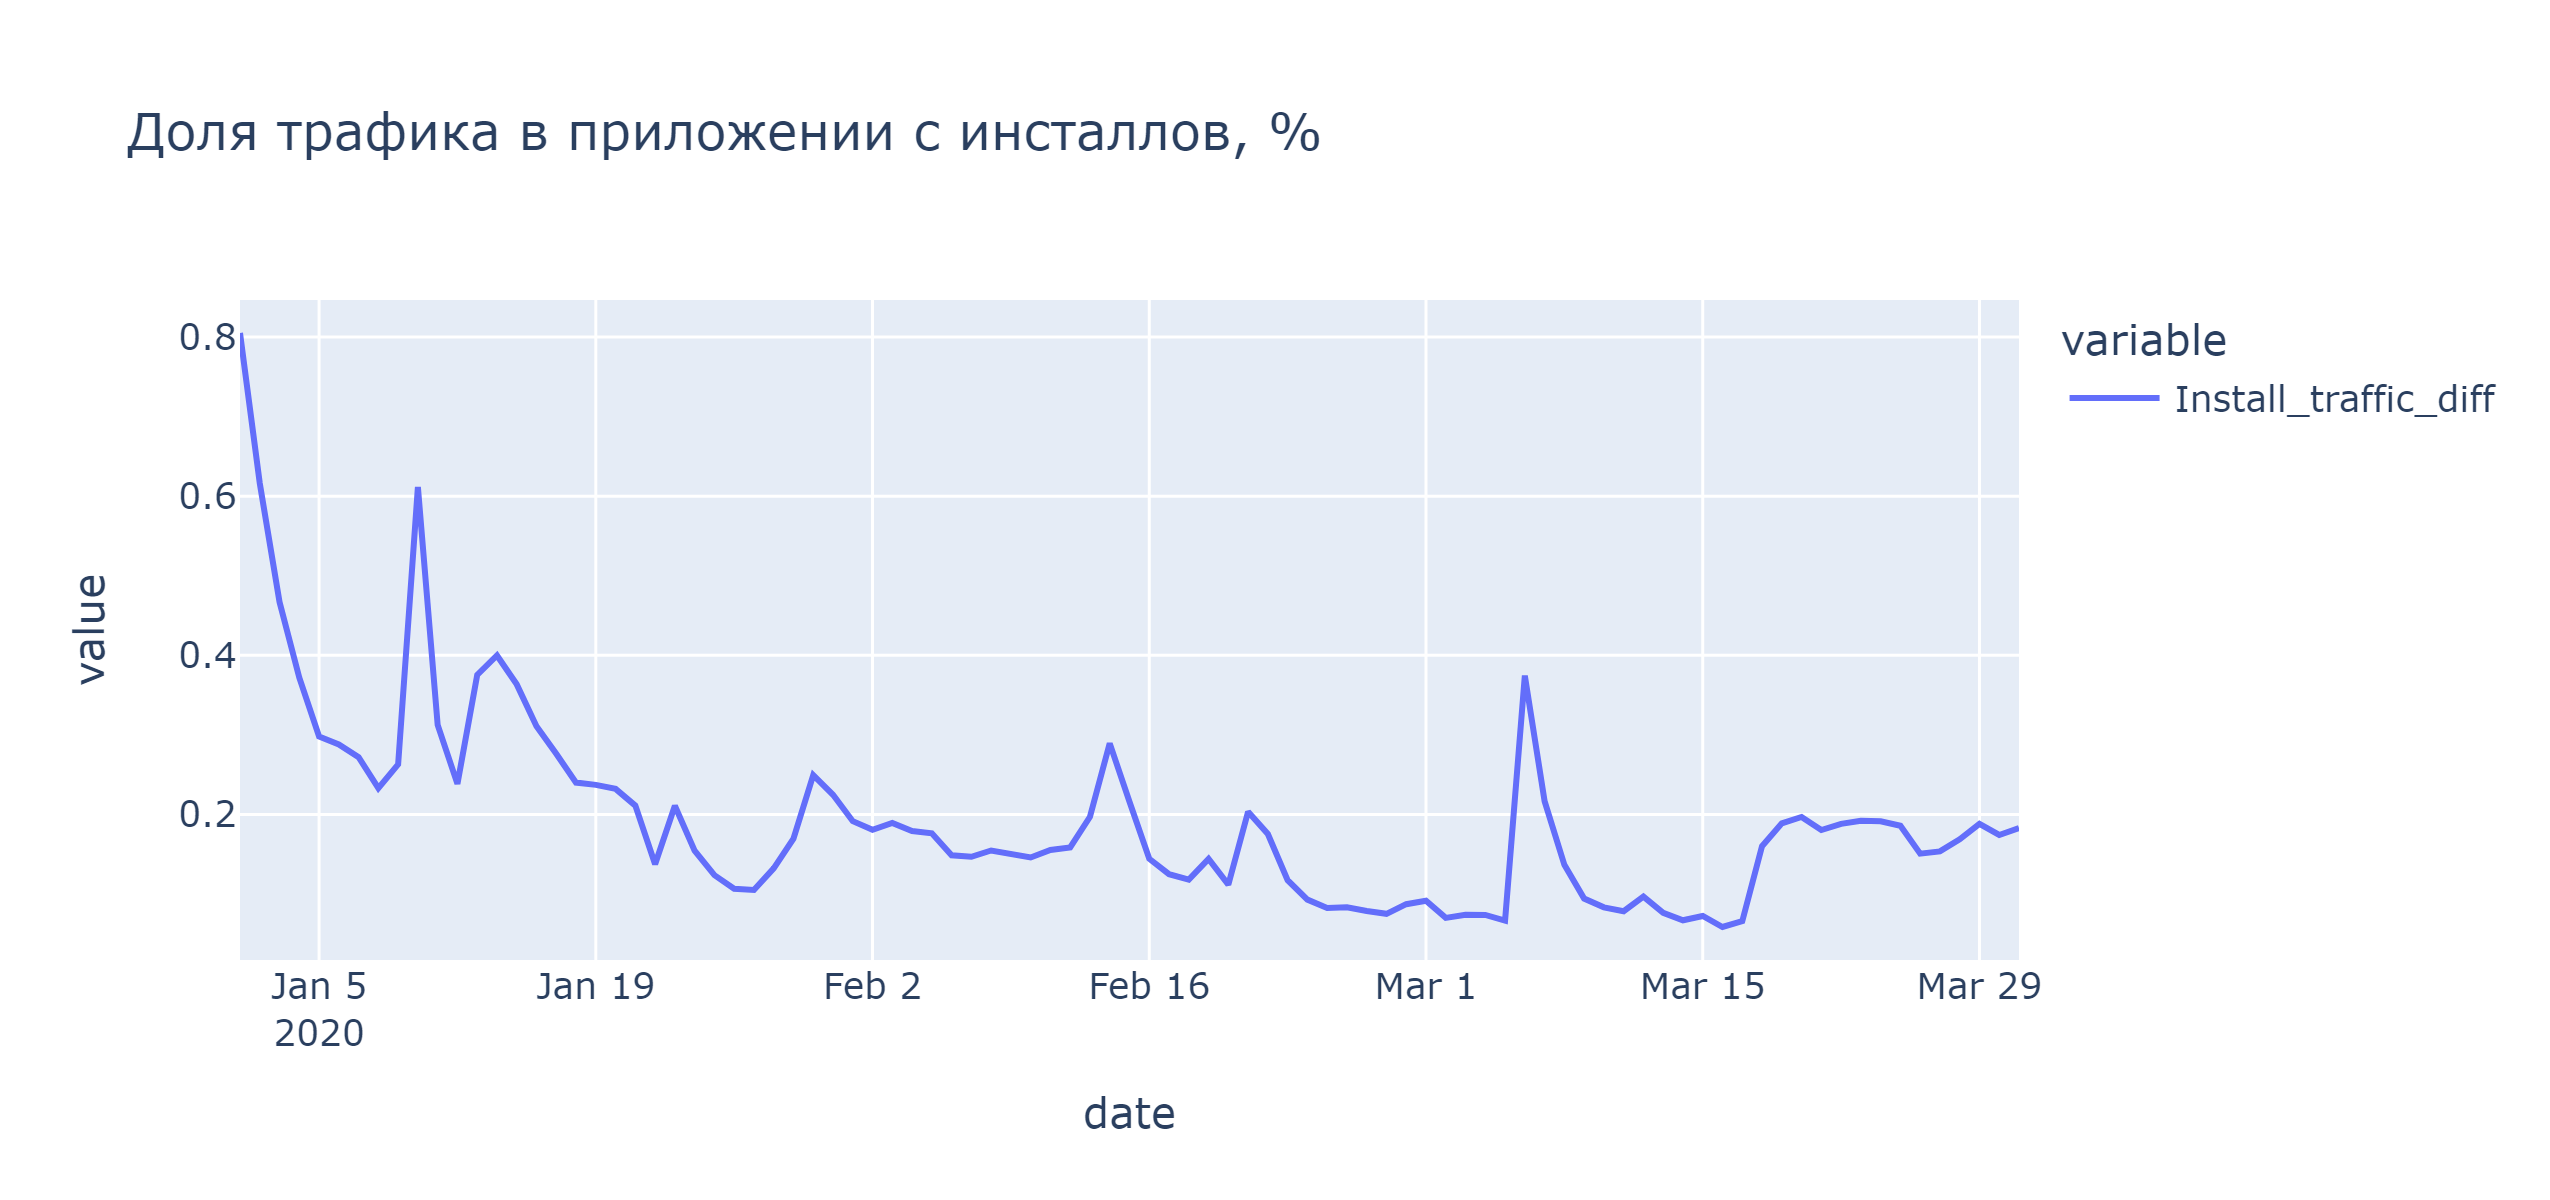

In [6]:
# создаем столбец с общим трафиком от открытия приложения в DataFrame с трафиком
traffic_table['Total_traffic'] = traffic_table['Остальные'] + traffic_table['Установили в тот же день']
# создаем столбец с долей трафика пользователей, которые открыли приложение в день установки
traffic_table['Install_traffic_diff'] = traffic_table['Установили в тот же день'] / traffic_table['Total_traffic']

# создаем график с трафиком пользователей, котрые установили приложение в тот же день относительно общего трафика
fig = px.line(
    data_frame=traffic_table['Install_traffic_diff'],
    height=500,
    width=1000,
    title='Доля трафика в приложении с инсталлов, %'
)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

День с максимальной долей трафика от инсталлов — 1 января, хотя в абсолютном выражении количество инсталов в этот день не максимальное (см. график трафика в приложении выше).

День с минимальной долей трафика от инсталлов — 16 марта.

Динамика установок приложения подтверждает тенденцию снижения. 

Рассмотрим динамику установки приложения в разрезе каналов привлечения пользователей.

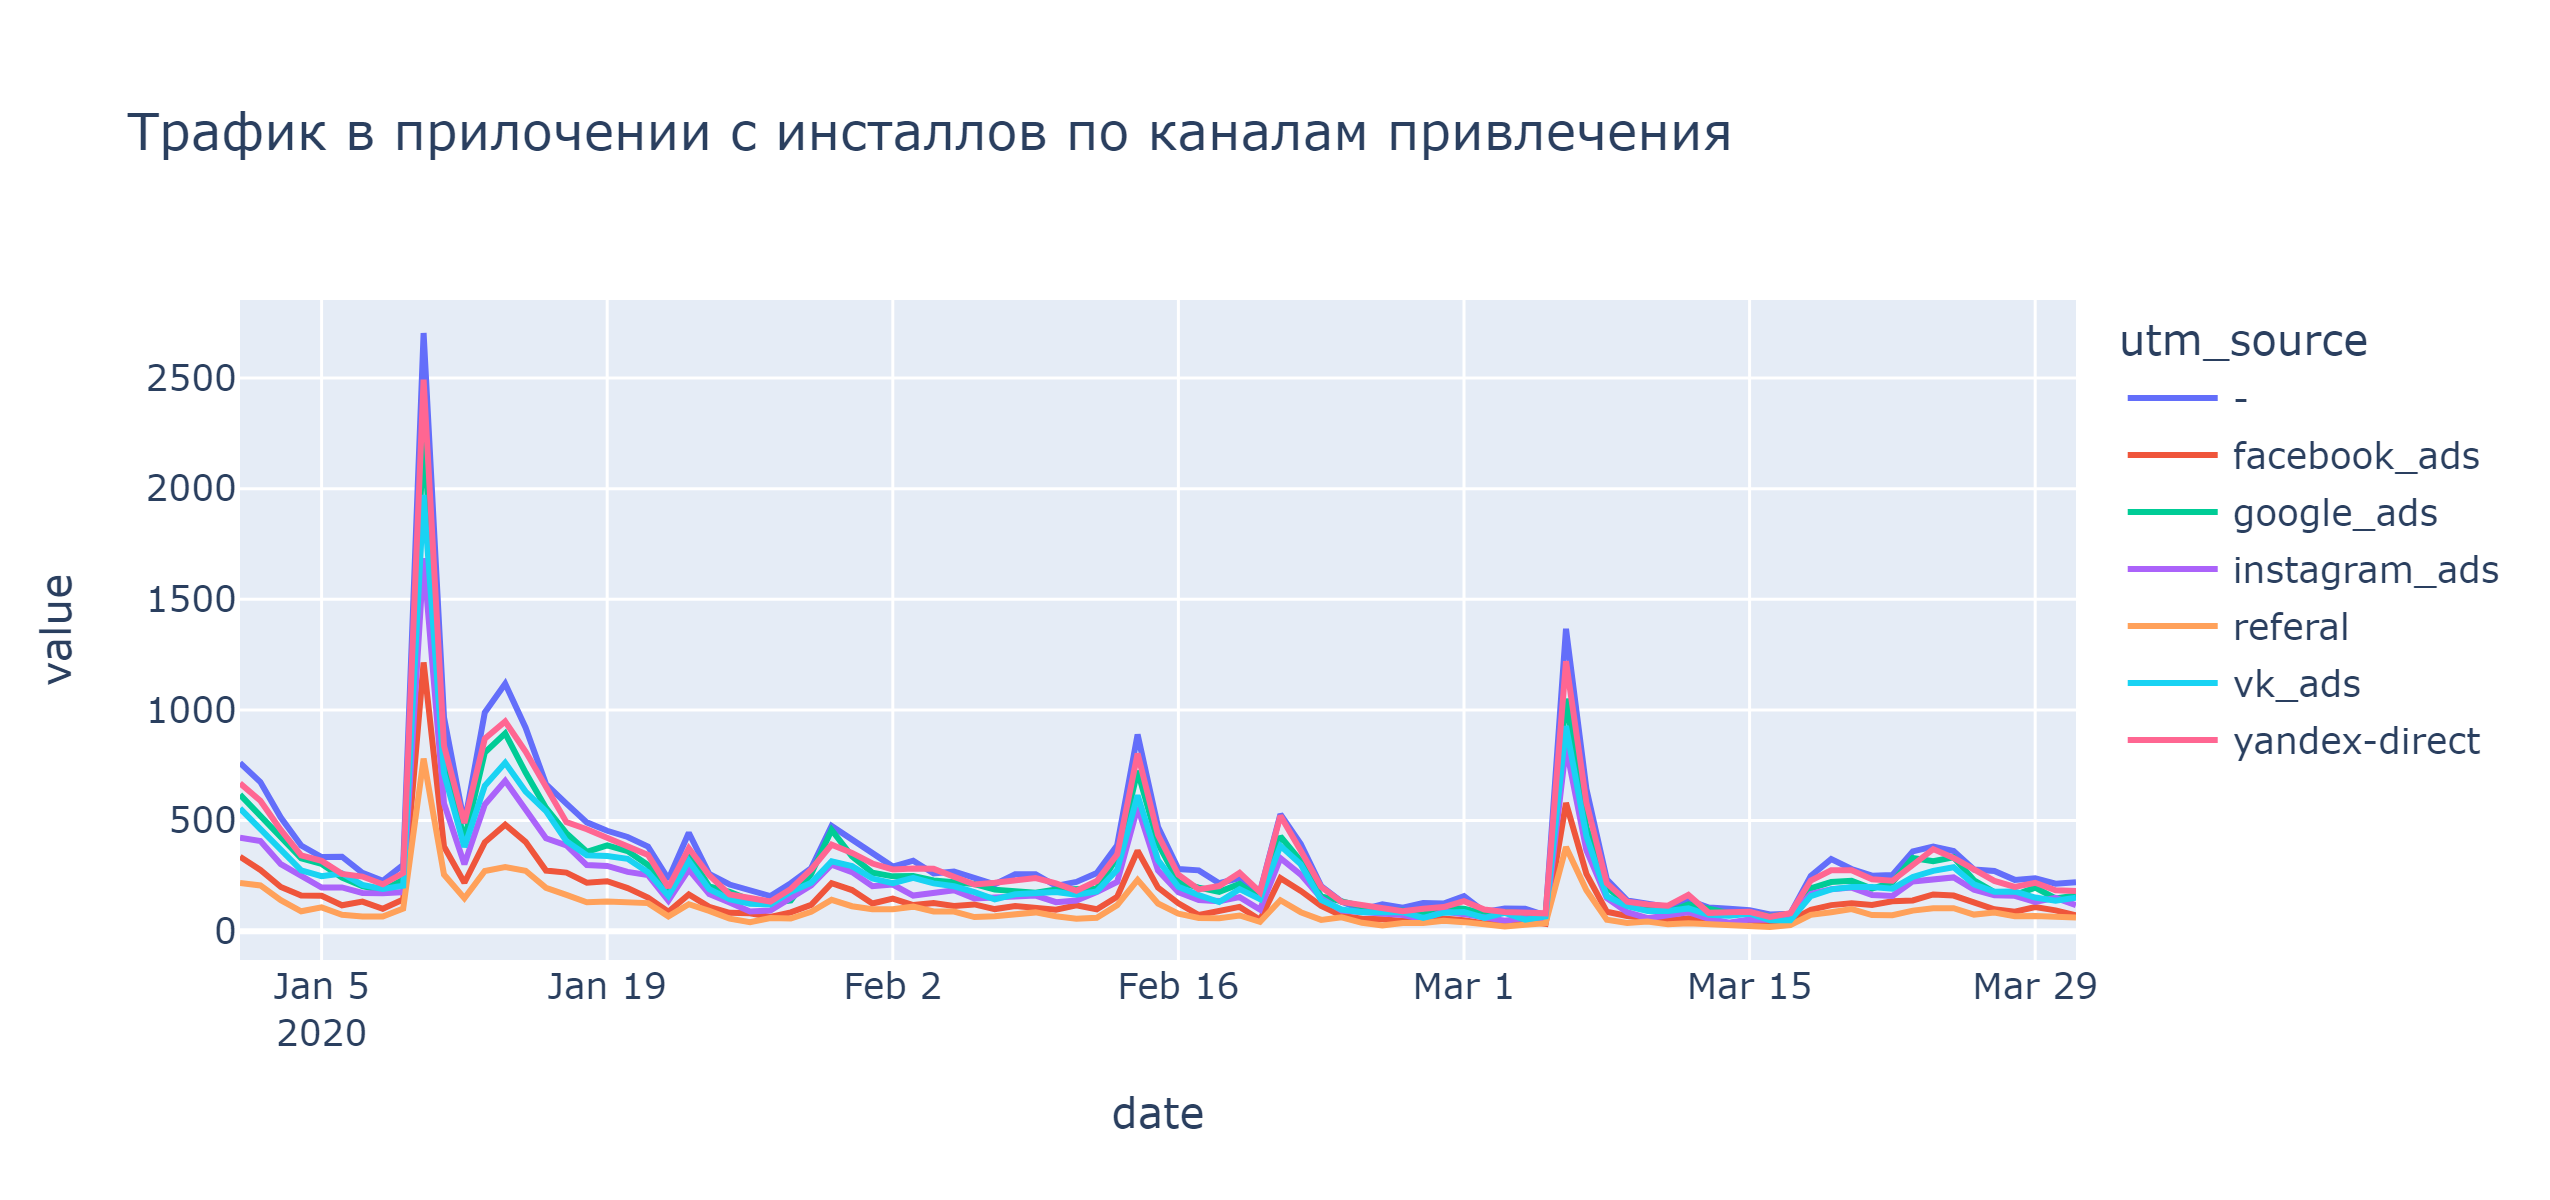

In [7]:
# сводим данные о количестве пользователей в разрезе даты установки приложения и каналах привлечения
source_data = data_df[data_df['event'] == 'app_install'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        ).groupby(
            ['date', 'utm_source']
            ).size()
# формируем DataFrame из полученных данных
source_table = source_data.unstack(level='utm_source')

# создаем график с количеством установок приложения пользователями по дням и по каналам привлечения
fig = px.line(
    data_frame=source_table,
    height=500,
    width=1000,
   title='Трафик в прилочении с инсталлов по каналам привлечения'
)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

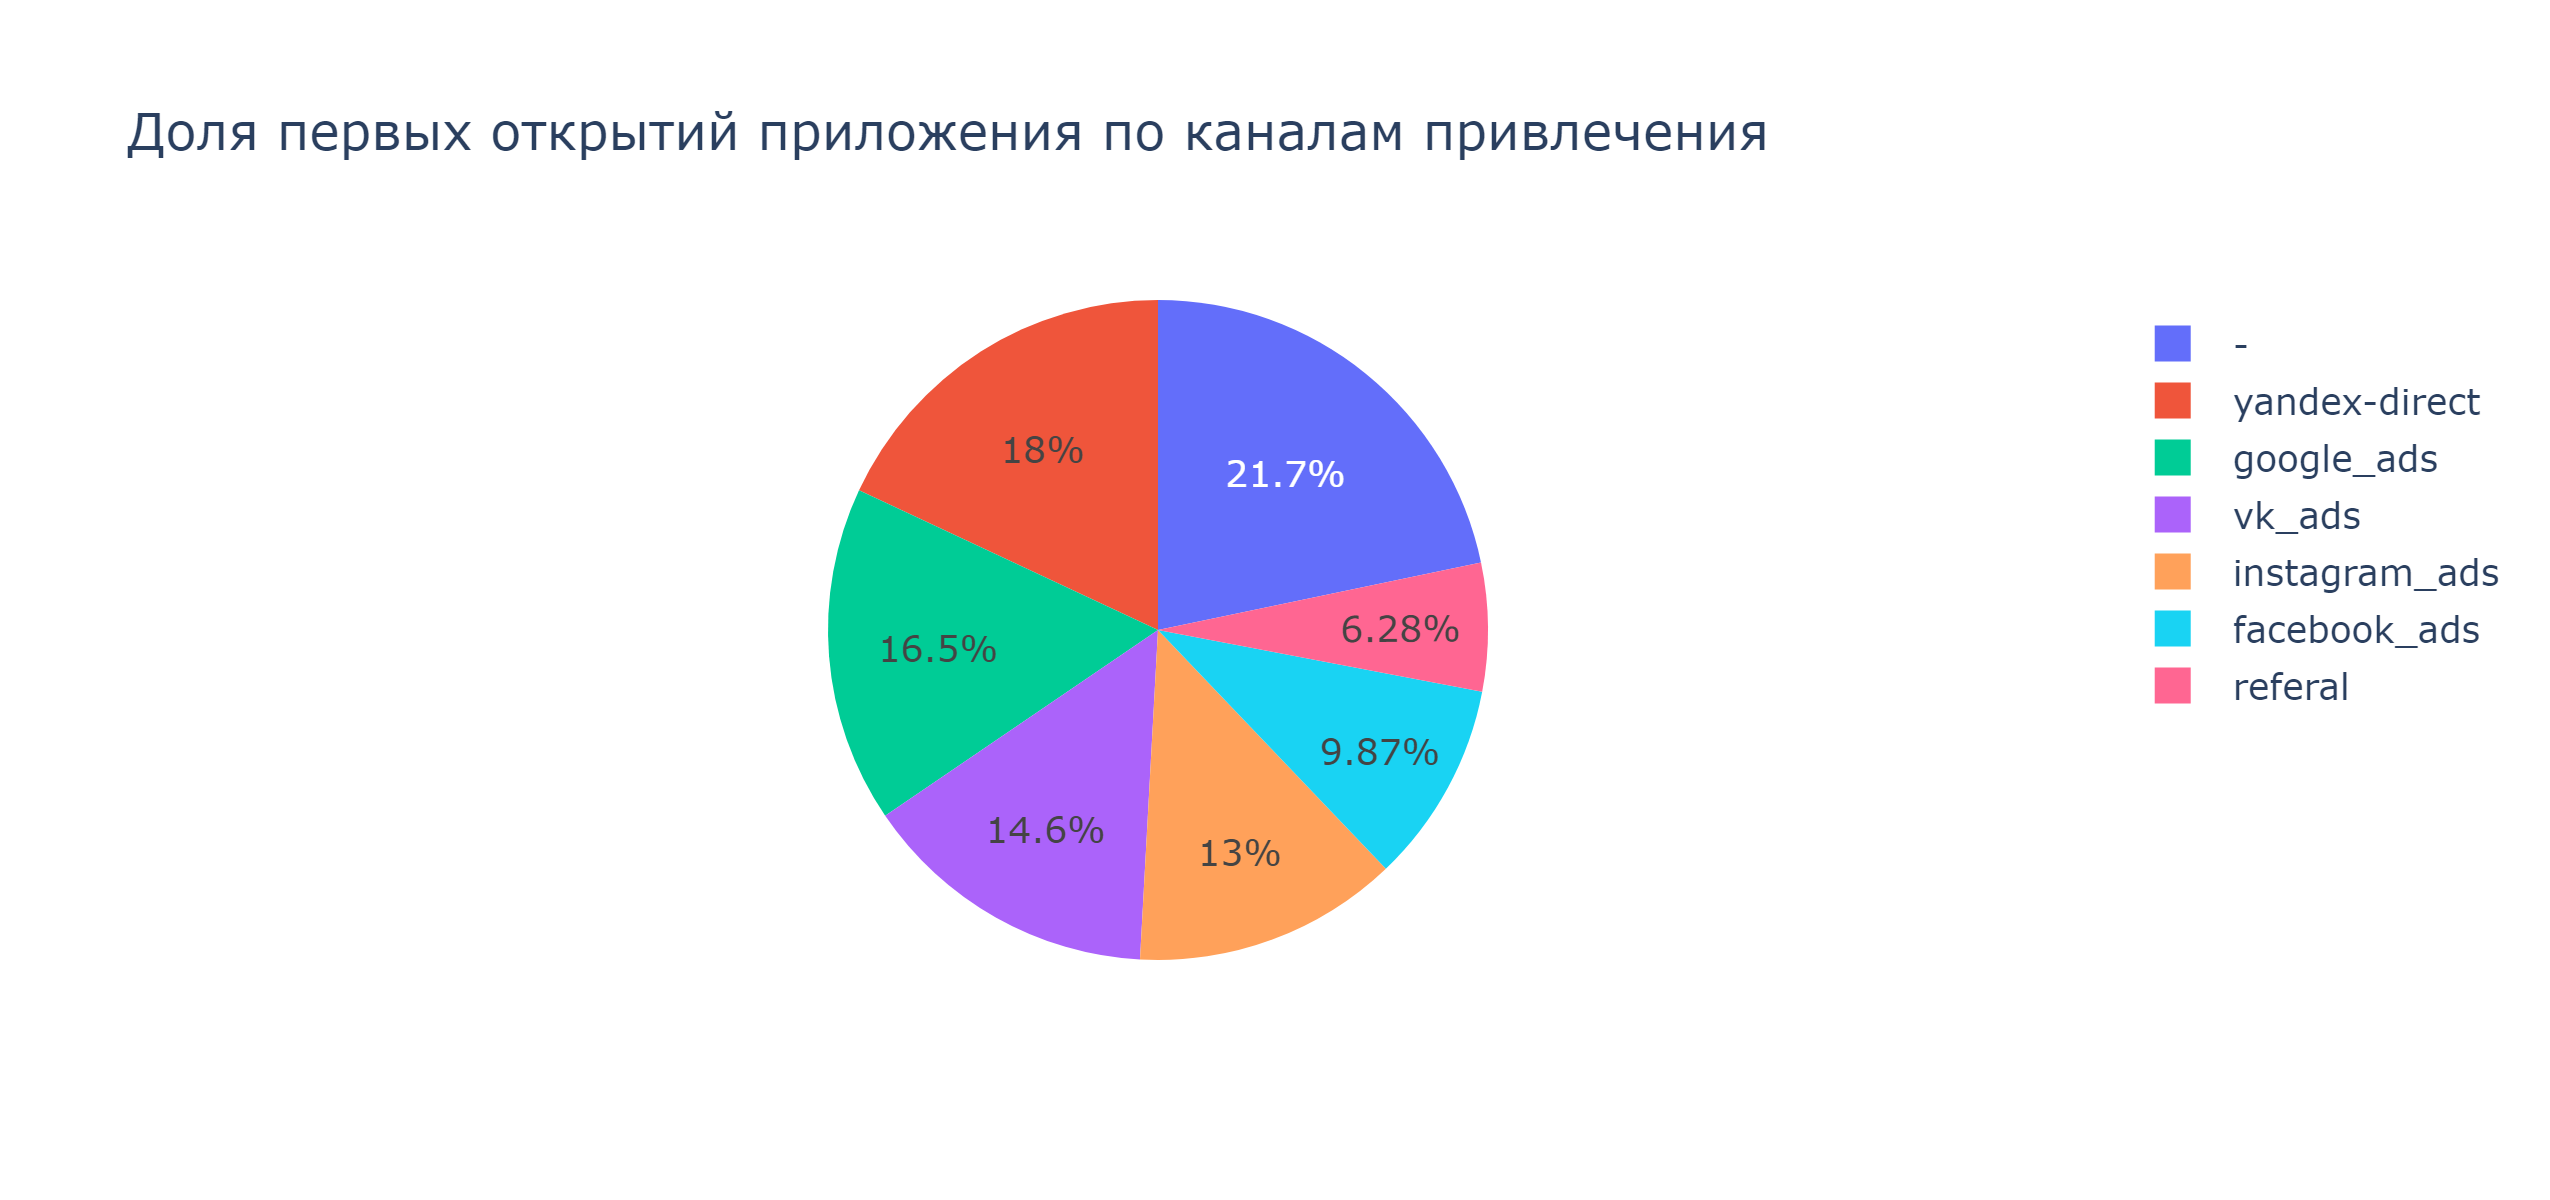

In [8]:
# сводим данные о количестве пользователей в разрезе даты открытия приложения и каналу привлечения 
first_traffic_sources_data = data_df[data_df['event'] == 'app_start'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        ).groupby(
            ['date', 'utm_source']
            ).size().reset_index(name = 'users')

# формирую диаграмму с долей пользователей в приложении по каналам привлечения
fig = px.pie(
    data_frame=first_traffic_sources_data,
    values = 'users',
    names = 'utm_source',
    title='Доля первых открытий приложения по каналам привлечения'
)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Яндекс приносит компании больше всего новых пользователей - 18% в Q1. На втором месте - Гугл. Кроме того, Яндекс занимает лидирующее положение на протяжении всего квартала.

Меньше всего пользователей приходят по Реферальной программе - 6,28%. 

Рассмотри воронку прохождения этапов приложения пользователями.

In [9]:
# создаем DF с данными о регистрации пользователей в приложении
first_reg_df = data_df[data_df['event'] == 'register'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id')

# создаем в основном DF колонку с датой регистрации, перетягия дату с предыдушего DF методом map
data_df['first_reg_date'] = data_df['device_id'].map(
    first_reg_df.set_index(
        'device_id')['date'])

# создаем DF с данными о пользователях, которые уже зарегистрированы в приложении
already_registered = data_df[data_df['first_reg_date'] < data_df['date']].copy()
# создаем столбец в новом DF со статусом регистрации пользователя 
already_registered['registered'] = 1

# создаем DF с пользователями, которые не прошли регистрацию в приложении
requires_reg1 = data_df[
    (data_df['first_reg_date'].isna() == True)].copy()
# создаем столбец в новом DF со статусом регистрации пользователя
requires_reg1['registered'] = 0

# создаем DF с пользователями, которые зарегистрировались в приложении перед покупкой
requires_reg2 = data_df[data_df['first_reg_date'] >= data_df['date']].copy()
# создаем столбец в новом DF со статусом регистрации пользователя
requires_reg2['registered'] = 0

# создаем новый DF, соединяя все созданные DF со статусом регистрации пользователей
data = pd.concat(
    [already_registered, 
     requires_reg1, 
     requires_reg2]
).reset_index()

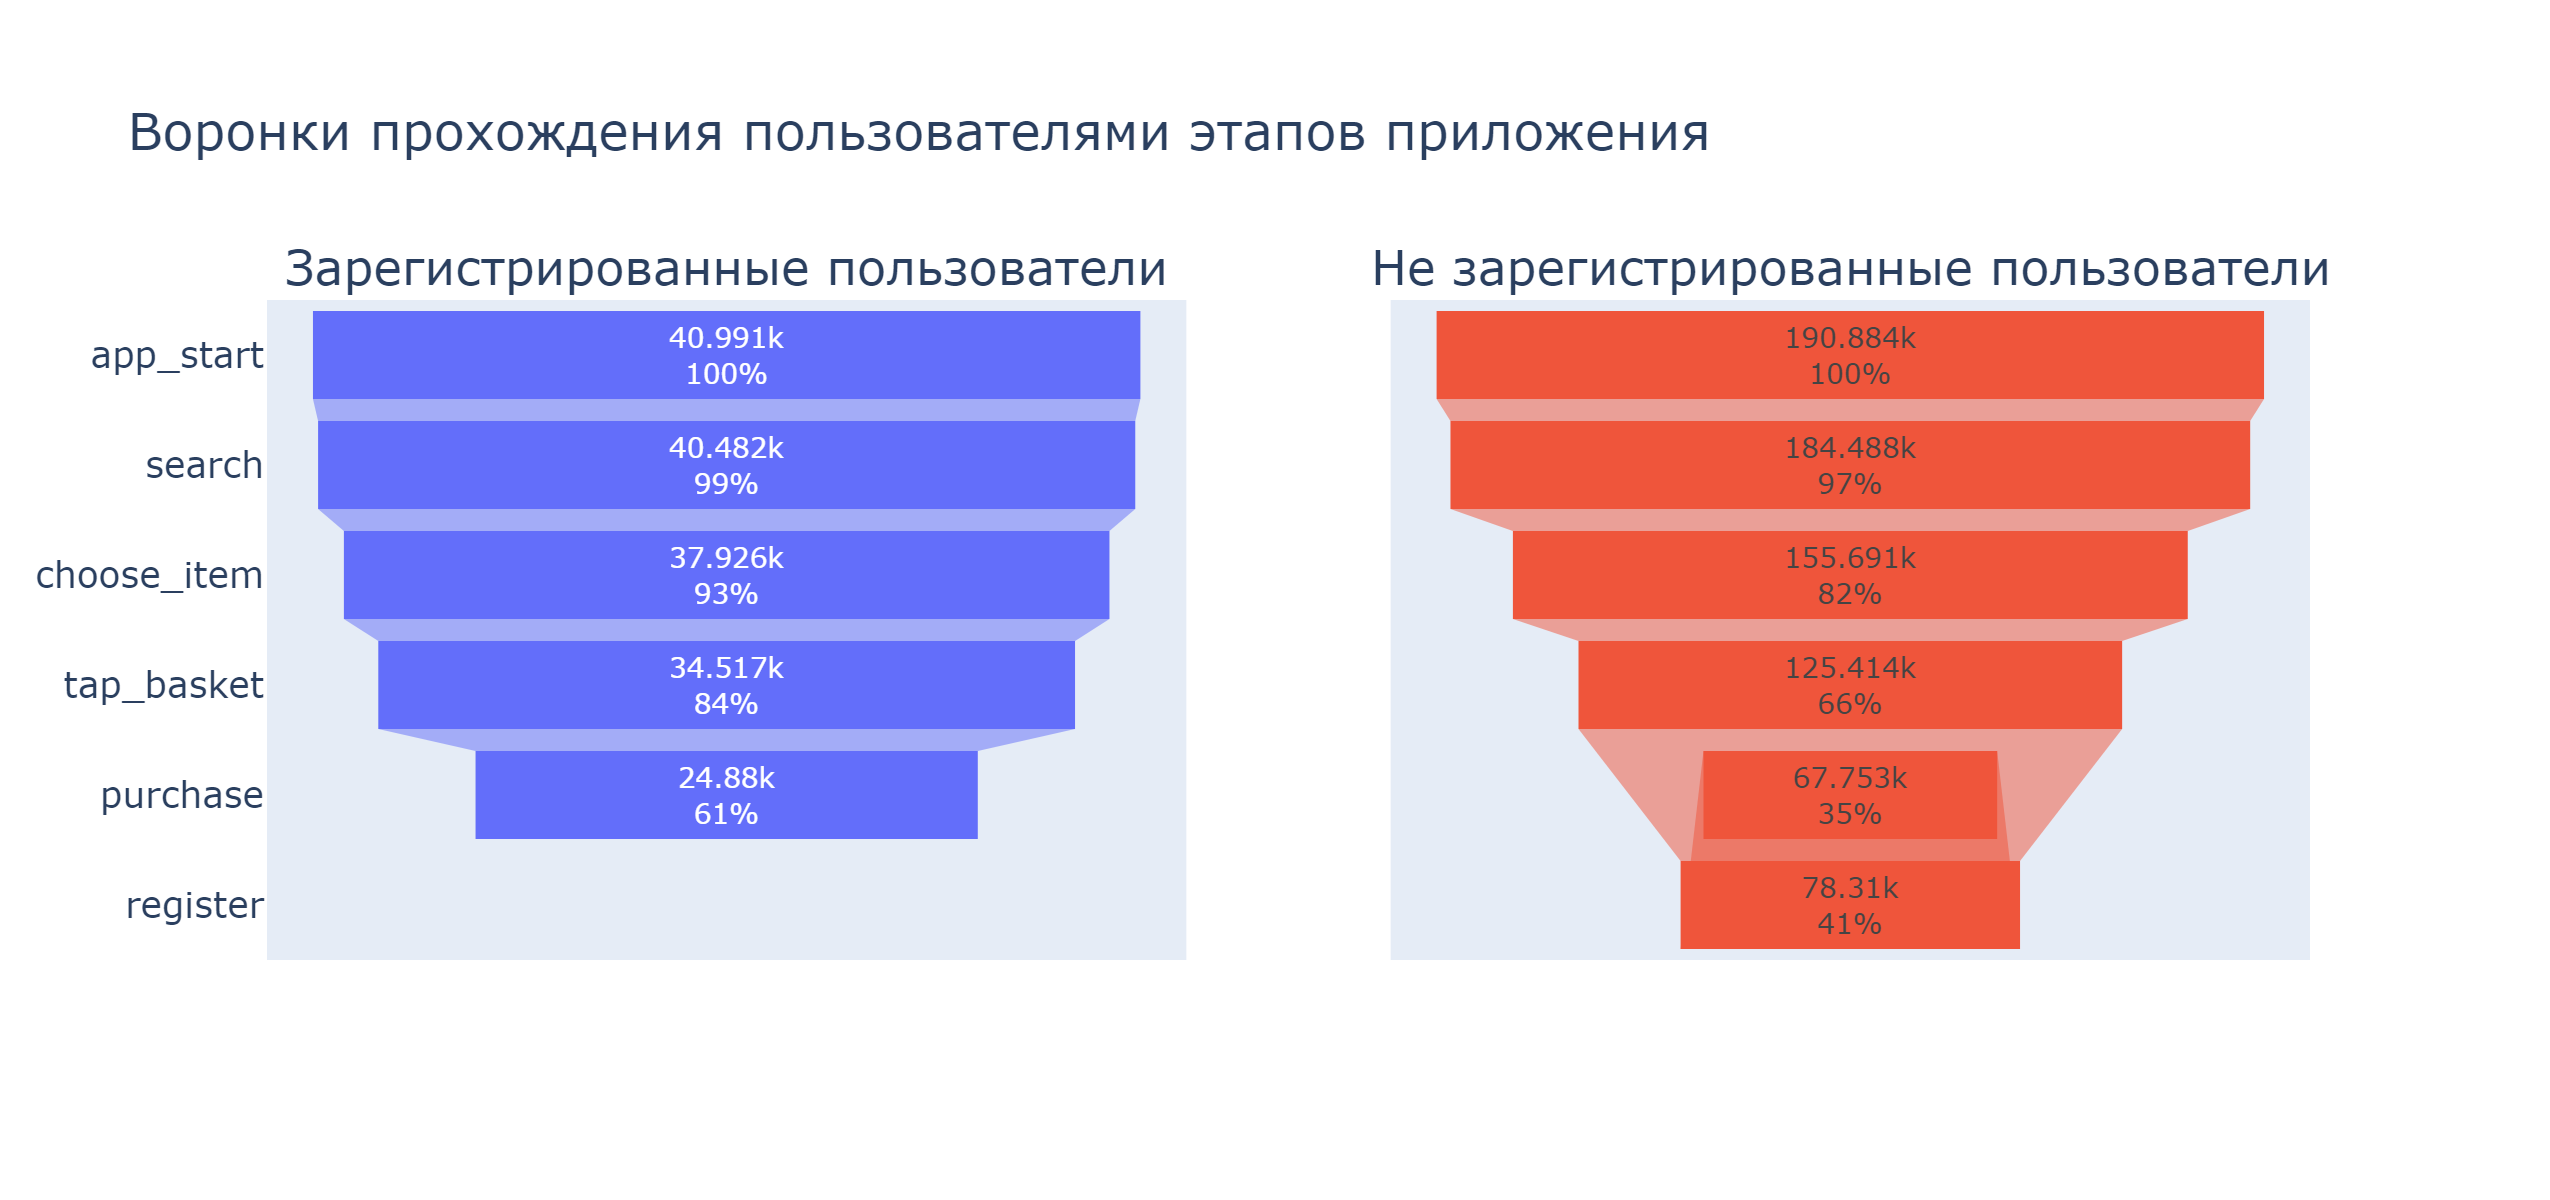

In [10]:
# создаем сводную таблицу с данными о количестве пользователей, 
# которые уже зарегистрировались, на разных этапах приложения
pivot_1 = pd.pivot_table(
    data=data[data['registered'] == 1],
    values=['device_id'],
    columns=['registered'],
    index=['event'],
    aggfunc='nunique'
)
pivot_1.columns = list(
    map(lambda x: x[-1], pivot_1)
)
pivot_1.rename(
    columns={1: 'registered'}, 
    inplace=True
)
pivot_1.sort_values(
    'registered', 
    ascending=False, 
    inplace=True
)
pivot_1 = pivot_1.reset_index()

# создаем сводную таблицу с данными о количестве пользователей, 
# которые не зарегистрировались или зарегистрировались перед покупкой, 
# на разных этапах приложения
pivot_2 = pd.pivot_table(
    data=data[data['registered'] == 0],
    values=['device_id'],
    columns=['registered'],
    index=['event'],
    aggfunc='nunique'
)
pivot_2.columns = list(
    map(lambda x: x[-1], pivot_2)
)
pivot_2.rename(
    columns={0: 'not_registered'}, 
    inplace=True
)
pivot_2.sort_values(
    'not_registered', 
    ascending=False, 
    inplace=True
)
pivot_2 = pivot_2.reset_index()

pivot_2.drop(
    index=[3], 
    inplace=True
)

# создаем поле для визуализацией воронок разных групп пользователей
fig = make_subplots(rows=1, 
                    cols=2, 
                    shared_yaxes=True, 
                    subplot_titles=('Зарегистрированные пользователи', 
                                    'Не зарегистрированные пользователи')
)

# создаем воронку зарегистрированных пользователей
fig.add_trace(go.Funnel(
    name = 'registered users',
    y = pivot_1['event'],
    x = pivot_1['registered'].values,
    textinfo = 'value+percent initial'
    ), row=1, col=1
)

# создаем воронку не зарегистрированных/зарегистрированных перед покупкой пользователей
fig.add_trace(go.Funnel(
    name = 'non registered users',
    orientation = 'h',
    y = pivot_2['event'],
    x = pivot_2['not_registered'].values,
    textposition = 'inside',
    textinfo = 'value+percent initial'
    ),row=1, col=2
)

fig.update_layout(
    showlegend=False, 
    title_text='Воронки прохождения пользователями этапов приложения'
)
# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Пользователи не могут совершить покупку, не зарегистрировавшись. Однако, не все пользователи проходят этап регистрации сразу.

Несмотря на то, что большая часть зарегистрированных пользователей отваливается на последнем шаге, более 60% зарегистрированных пользователей доходят до этапа этапа покупки (более 70% тех пользователей, которые перешли в корзину).

Больше всего незарегистрированных пользователей отваливается на шаге регистрации. Что подтверждает ранее сформулированные промежуточные выводы о том, что этап регистрации может отпугивать пользователей. Стоит подумать над тем, как можно упростить и ускорить этот шаг. 

Увеличение числа зарегистрированных пользователей может стать точкой роста и соответственно увеличить объем продаж.

Возможно, также, стоит мотивировать пользователей пройти регистрации предлагая промокод или скидку на первую покупку.

In [11]:
# создаем DF с данными о количестве зарегистрированных пользователей 
# на разных этапах приложения в разрезе каналов привлечения
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(
    reg['utm_source'], 
    reg['event'], 
    values=reg['device_id'], 
    aggfunc=pd.Series.nunique, 
    margins=True
)
# задаем порядом событий в созданном DF
upd_funnel_reg = funnel_reg.reindex(
    columns=['app_start', 
             'search', 
             'choose_item', 
             'tap_basket', 
             'purchase', 
             'All'])

# создаем доп.столбы с данными о доле пользователей на этапах приложения
upd_funnel_reg['1 step'] = upd_funnel_reg['search']*100/upd_funnel_reg['app_start']
upd_funnel_reg['2 step'] = upd_funnel_reg['choose_item']*100/upd_funnel_reg['search']
upd_funnel_reg['3 step'] = upd_funnel_reg['tap_basket']*100/upd_funnel_reg['choose_item']
upd_funnel_reg['5 step'] = upd_funnel_reg['purchase']*100/upd_funnel_reg['tap_basket']

upd_funnel_reg

event          app_start  search  choose_item  tap_basket  purchase    All  \
utm_source                                                                   
-                   9482    9355         8728        7850      5492   9485   
facebook_ads        5606    5527         5154        4694      3333   5609   
google_ads          5399    5335         4948        4438      3121   5404   
instagram_ads       5686    5618         5288        4842      3548   5686   
referal             3647    3610         3417        3155      2382   3649   
vk_ads              6011    5958         5636        5196      3950   6014   
yandex-direct       5396    5304         4928        4464      3099   5396   
All                40991   40482        37926       34517     24880  41007   

event             1 step     2 step     3 step     5 step  
utm_source                                                 
-              98.660620  93.297702  89.940422  69.961783  
facebook_ads   98.590796  93.251312  91.074893  71.005539  
google_ads     98.814595  92.746017  89.692805  70.324470  
instagram_ads  98.804080  94.126023  91.565809  73.275506  
referal        98.985468  94.653740  92.332455  75.499208  
vk_ads         99.118283  94.595502  92.193045  76.020015  
yandex-direct  98.295033  92.911011  90.584416  69.422043  
All            98.758264  93.686083  91.011443  72.080424

Среди зарегистрированных пользователей, больше всего пользователей пришли с рекламы в ВК, также именно большая часть этих пользователей дошли до этапа покупки (76%).

Меньше всего пользователей привела Реферальная программа, однако 75% этих пользователей, которые перешли в корзину, дошли до этапа покупки. 

In [12]:
# создаем DF с данными о незарегистрированных/зареистрированных перед покупкой пользователях 
# на разных этапах приложения в разрезе каналов привлечения
not_reg = data[data['registered'] == 0]
funnel_not_reg = pd.crosstab(
    not_reg['utm_source'], 
    not_reg['event'], 
    values=not_reg['device_id'], 
    aggfunc=pd.Series.nunique, 
    margins=True
)
# задаем порядок событий в созданном DF
upd_funnel_not_reg = funnel_not_reg.reindex(
    columns=['app_install', 
             'app_start', 
             'search', 
             'choose_item', 
             'tap_basket', 
             'register', 
             'purchase']
)

# создаем доп.столбцы с данными о долях пользователей на разных этапах приложения 
upd_funnel_not_reg['1 step'] = upd_funnel_not_reg['search']*100/upd_funnel_not_reg['app_start']
upd_funnel_not_reg['2 step'] = upd_funnel_not_reg['choose_item']*100/upd_funnel_not_reg['search']
upd_funnel_not_reg['3 step'] = upd_funnel_not_reg['tap_basket']*100/upd_funnel_not_reg['choose_item']
upd_funnel_not_reg['4 step'] = upd_funnel_not_reg['register']*100/upd_funnel_not_reg['tap_basket']
upd_funnel_not_reg['5 step'] = upd_funnel_not_reg['purchase']*100/upd_funnel_not_reg['register']

upd_funnel_not_reg

event          app_install  app_start  search  choose_item  tap_basket  \
utm_source                                                               
-                    32460      48670   46742        38026       29223   
facebook_ads         13916      23780   22822        18713       14592   
google_ads           26286      35778   34217        27416       20765   
instagram_ads        20096      29237   28017        22858       17881   
referal               9282      14866   14316        11880        9518   
vk_ads               23189      32353   31010        25422       20014   
yandex-direct        29368      38578   36933        29591       22417   
All                 154597     190884  184488       155691      125414   

event          register  purchase     1 step     2 step     3 step     4 step  \
utm_source                                                                      
-                 16527     14073  96.038627  81.352959  76.850050  56.554769   
facebook_ads       8672      7506  95.971405  81.995443  77.977876  59.429825   
google_ads        11405      9777  95.636984  80.123915  75.740444  54.924151   
instagram_ads     10750      9394  95.827205  81.586180  78.226442  60.119680   
referal            6193      5503  96.300283  82.984074  80.117845  65.066190   
vk_ads            12421     10919  95.848917  81.980006  78.727087  62.061557   
yandex-direct     12342     10581  95.735912  80.120759  75.756142  55.056430   
All               78310     67753  96.649274  84.390855  80.553147  62.441195   

event             5 step  
utm_source                
-              85.151570  
facebook_ads   86.554428  
google_ads     85.725559  
instagram_ads  87.386047  
referal        88.858389  
vk_ads         87.907576  
yandex-direct  85.731648  
All            86.518963

Среди незарегистрированных пользователей больше всего пользователей пришли по рекламе Яндекс. По Реферальной программе также пришло меньшее количество пользователей, однако в этой группе пользователей самая высокая конверсия в покупку (88% тех, кто перешел в корзину).

In [13]:
# создаем DF с данными о первых открытий приложения пользователями в разрезе каналов привлечения
first_views = data[data['event'] == 'app_start'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        ).groupby(
            ['utm_source']
            ).size().reset_index(name = 'first_views_qty')

# создаем DF с данными первых покупок пользователей в разрезе калов привлечения
first_purchases = data[data['event'] == 'purchase'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        ).groupby(
            ['utm_source']
            ).size().reset_index(name = 'first_purchases_qty')

# соединяем полученные DF 
cr_data = first_views.merge(
    first_purchases, 
    how = 'left', 
    on = 'utm_source'
)
# создаем доп.столбец с данными о доле пользователей, совершивших покупку, относительно 
# пользователей открывших приложения в разрезе каналов привлечения
cr_data['CR'] = cr_data['first_purchases_qty']/cr_data['first_views_qty']
cr_data.sort_values('CR', ascending=False)

utm_source  first_views_qty  first_purchases_qty        CR
4        referal            11983                 5803  0.484269
1   facebook_ads            18844                 7903  0.419391
5         vk_ads            27905                11460  0.410679
3  instagram_ads            24818                 9820  0.395681
0              -            41456                14786  0.356667
2     google_ads            31437                10167  0.323409
6  yandex-direct            34441                10936  0.317529

Если смотреть на данные за весь квартал агрегировано, то мы видим, что довольно большая часть пользователей всё-таки совершает свою первую покупку (не в день первого захода, а даже спустя какое-то время). Самый большой CR — у реферальной программы (48,4%), а самый маленький — у Яндекс.Директа (31,8%).

In [14]:
# создаем DF с данными о средней и медеаной суммах первых покупок пользователей в разрезе каналов привлечения
first_purchases_amt= data[data['event'] == 'purchase'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        ).groupby(
            ['utm_source']
            )['purchase_sum'].agg(
                ['mean', 'median']
                ).reset_index()
            
first_purchases_amt.sort_values(
    'median', 
    ascending=False
)


utm_source        mean  median
0              -  698.211078   398.5
4        referal  696.420128   395.5
3  instagram_ads  716.201018   393.5
5         vk_ads  716.480192   393.0
6  yandex-direct  725.740719   392.5
2     google_ads  700.920134   390.5
1   facebook_ads  692.090029   389.0

Медианный чек пользователей, пришедшие по реферальной программе, выше чем остальных пользователей.

Однако, максимальные чеки у других пользователей выше, о чем говорить смещение средних показателей у Яндекса, ВК и Инстаграм в большую сторону.

Рассчитаем ROMI для каналов привлечения пользователей.

In [15]:
# создаем DF с данными о маркетинговых затратах на разные каналы привлечения пользователей
marketing_costs_df = pd.DataFrame({
    'utm_source': ['yandex-direct', 
                   'google_ads', 
                   'facebook_ads', 
                   'instagram_ads', 
                   'vk_ads'],
    'costs': [10491707, 
              10534878, 
              8590498, 
              8561626, 
              9553531]
})

# создаем DF с данными о выручке в разрезе каналов привлечения
purchases_amt_df= data[data['event'] == 'purchase'].groupby(
    ['utm_source']
    )['purchase_sum'].sum().reset_index(name='revenue')

# соединяя полученные DF? создаем новый DF с данными о маркетинговых расходах 
# и выручке в разрезе каналов привлечения
romi_df = purchases_amt_df.merge(
    marketing_costs_df, 
    on='utm_source', 
    how='inner'
)
# создаем доп.столбец с данными о показателе ROMI
romi_df['ROMI'] = (romi_df['revenue'] - romi_df['costs']) / romi_df['costs'] * 100

romi_df.sort_values('ROMI', ascending=False)

utm_source     revenue     costs       ROMI
3         vk_ads  16389652.5   9553531  71.555967
2  instagram_ads  14546969.0   8561626  69.908952
0   facebook_ads  12249901.0   8590498  42.598264
4  yandex-direct  13915368.0  10491707  32.632068
1     google_ads  12868276.0  10534878  22.149265

In [16]:
# выводим данные о количестве пользователей, совершивших покупки, в разрезе каналов привлечения
data[data['event']=='purchase'].drop_duplicates(
    'device_id'
    )['utm_source'].value_counts()

-                15179
vk_ads           11135
yandex-direct    10608
google_ads        9968
instagram_ads     9787
facebook_ads      8324
referal           5874
Name: utm_source, dtype: int64

Самый высокий ROMI - у ВК (71 %). Скорее всего, это было достигнуто за счёт лояльности аудитории, пришедшей оттуда, а также их высокого LTV. Однако самая выгодная опция - реферальная программа, в рамках которой за 3 месяца 5 873 пользователей принесло 8 837 045 рублей. Это обошлось всего в 1 174 600 рублей (5 873 * 200 р. = 1 174 600 р., (8 837 045 - 1 174 600) / 1 174 600 = 652,3%).

Компания тратит больше всего средств на рекламу Яндекс и Гугл, однако у этих каналах самые низкие ROMI и CR. Возможно стоит рассмотреть вариант перераспределения расходов на маркетинг. 

## Выводы:

Анализ эффективности каналов привлечения и воронки продаж показал следующее:

1. Пики активности пользователей в Q1 приходились на периоды праздников. Так же в это время наблюдались приросты числа установок нашего приложения. Возможно это результат сезонности (всегда рост в праздники), либо это результат маркетинговых акций. Однако в общем наблюдается тенденция снижения всего трафика, в т.ч. и установок приложения. Что говорит, о том что маркетинг работает не так хорошо.

2. Больше всего новых пользователей приносит компании реклама Яндекс - 18%, Гугл - 16,5%. Однако, конверсия этих пользователей в покупку (CR) и возвращаемость маркетинговых затрат - наименьшие. Наибольшая конверсия в покупку у пользователей, которые пришли по Реферальной программе. Наибольший ROMI - от рекламы в ВК и Реферальной программы. Возможно компании стоит рассмотреть вариант перераспределения расходов на маркетинг.

3. Большинство пользователей отваливаются на этапе регистрации в приложении (без этого этапа пользователи не смогут совершить покупку). На этапе регистрации отваливаются около 40% пользователей, которые ранее не зарегистрировались и перешли в корзину. Увеличение числа зарегистрированных пользователей может стать для нас точкой роста. Более 70% ранее зарегистрированных пользователей доходят до этапа покупки. Стоит рассмотреть варианты упрощения этапа регистрации для пользователей. Возможно стоит также мотивировать пользователей регистрироваться, предлагая промокод или скидку на первую покупку.

## Когортный анализ

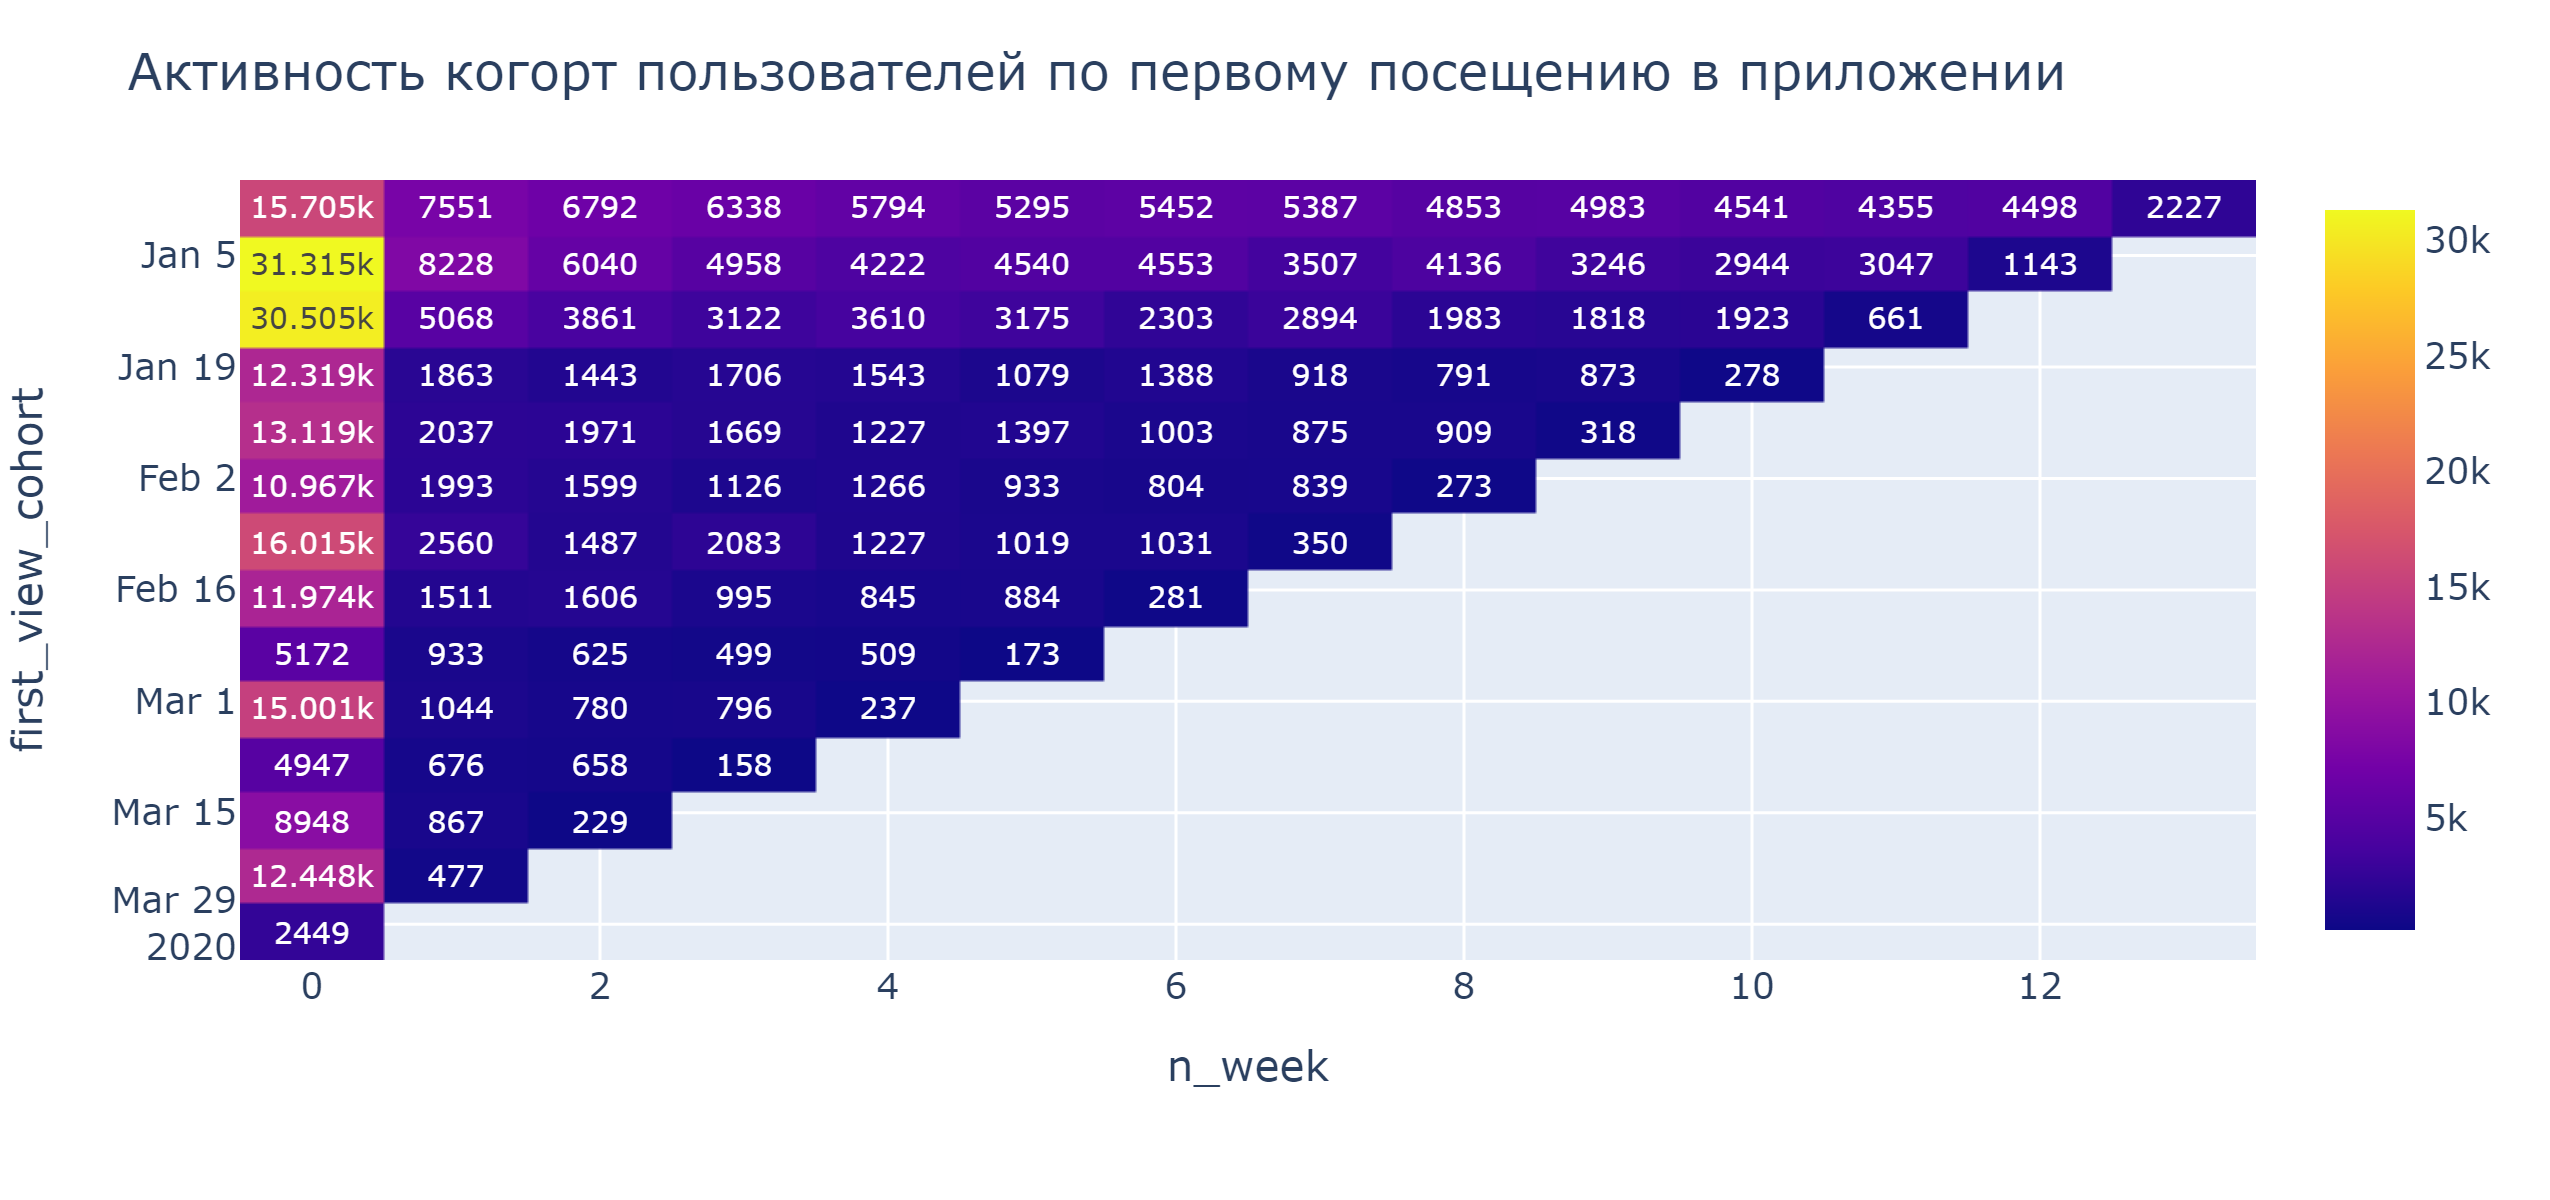

In [17]:
# создаем DF с датами первых посещений приложения
first_views = data[data['event'] == 'app_start'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
)
# добавляем в основной DF дату первого посещения приложения
data['first_view'] = data['device_id'].map(
    first_views.set_index(
        'device_id'
        )['date']
)
# определяем тип данных даты первого посещения
data['first_view'] = pd.to_datetime(
    data['first_view'], 
    format='%Y-%m-%d'
)
# создаем доп.столбец, где определяем когорта - дату начала недели
data['first_view_cohort'] = data['first_view'].apply(
    lambda x: x + dt.timedelta(
        days=-x.weekday(), 
        weeks=0)
)
# определяем тип данных даты события
data['date'] = pd.to_datetime(
    data['date'], 
    format = '%Y-%m-%d'
)
# создаем доп.столбец с количеством недель со дня первого посещения
data['n_week'] = data['date'] - data['first_view_cohort']
data['n_week'] = data['n_week'].apply(
    lambda x: x.days // 7
)
# меняем тип данных когорты первого посещения на str для создания визуализации
data['first_view_cohort'] = data['first_view_cohort'].apply(
    lambda x: str(x)[:10]
)

# создаем сводную таблицу для визуализации количества пользователей в когортах недели первого посещия
viz_pivot = data.pivot_table(
    index='first_view_cohort', 
    columns='n_week', 
    values='device_id', 
    aggfunc=pd.Series.nunique
)

fig = px.imshow(viz_pivot, 
                text_auto=True)

fig.update_layout(
    title='Активность когорт пользователей по первому посещению в приложении')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Самыми большими когортами по первому посещению являются когорты 6 и 13 января. Возможно это связанно с сезонностью (т.е. к этому периоду люди доедают свой НГ стол)

Самой маленькой когортой является когорта 30.03.2020 г.

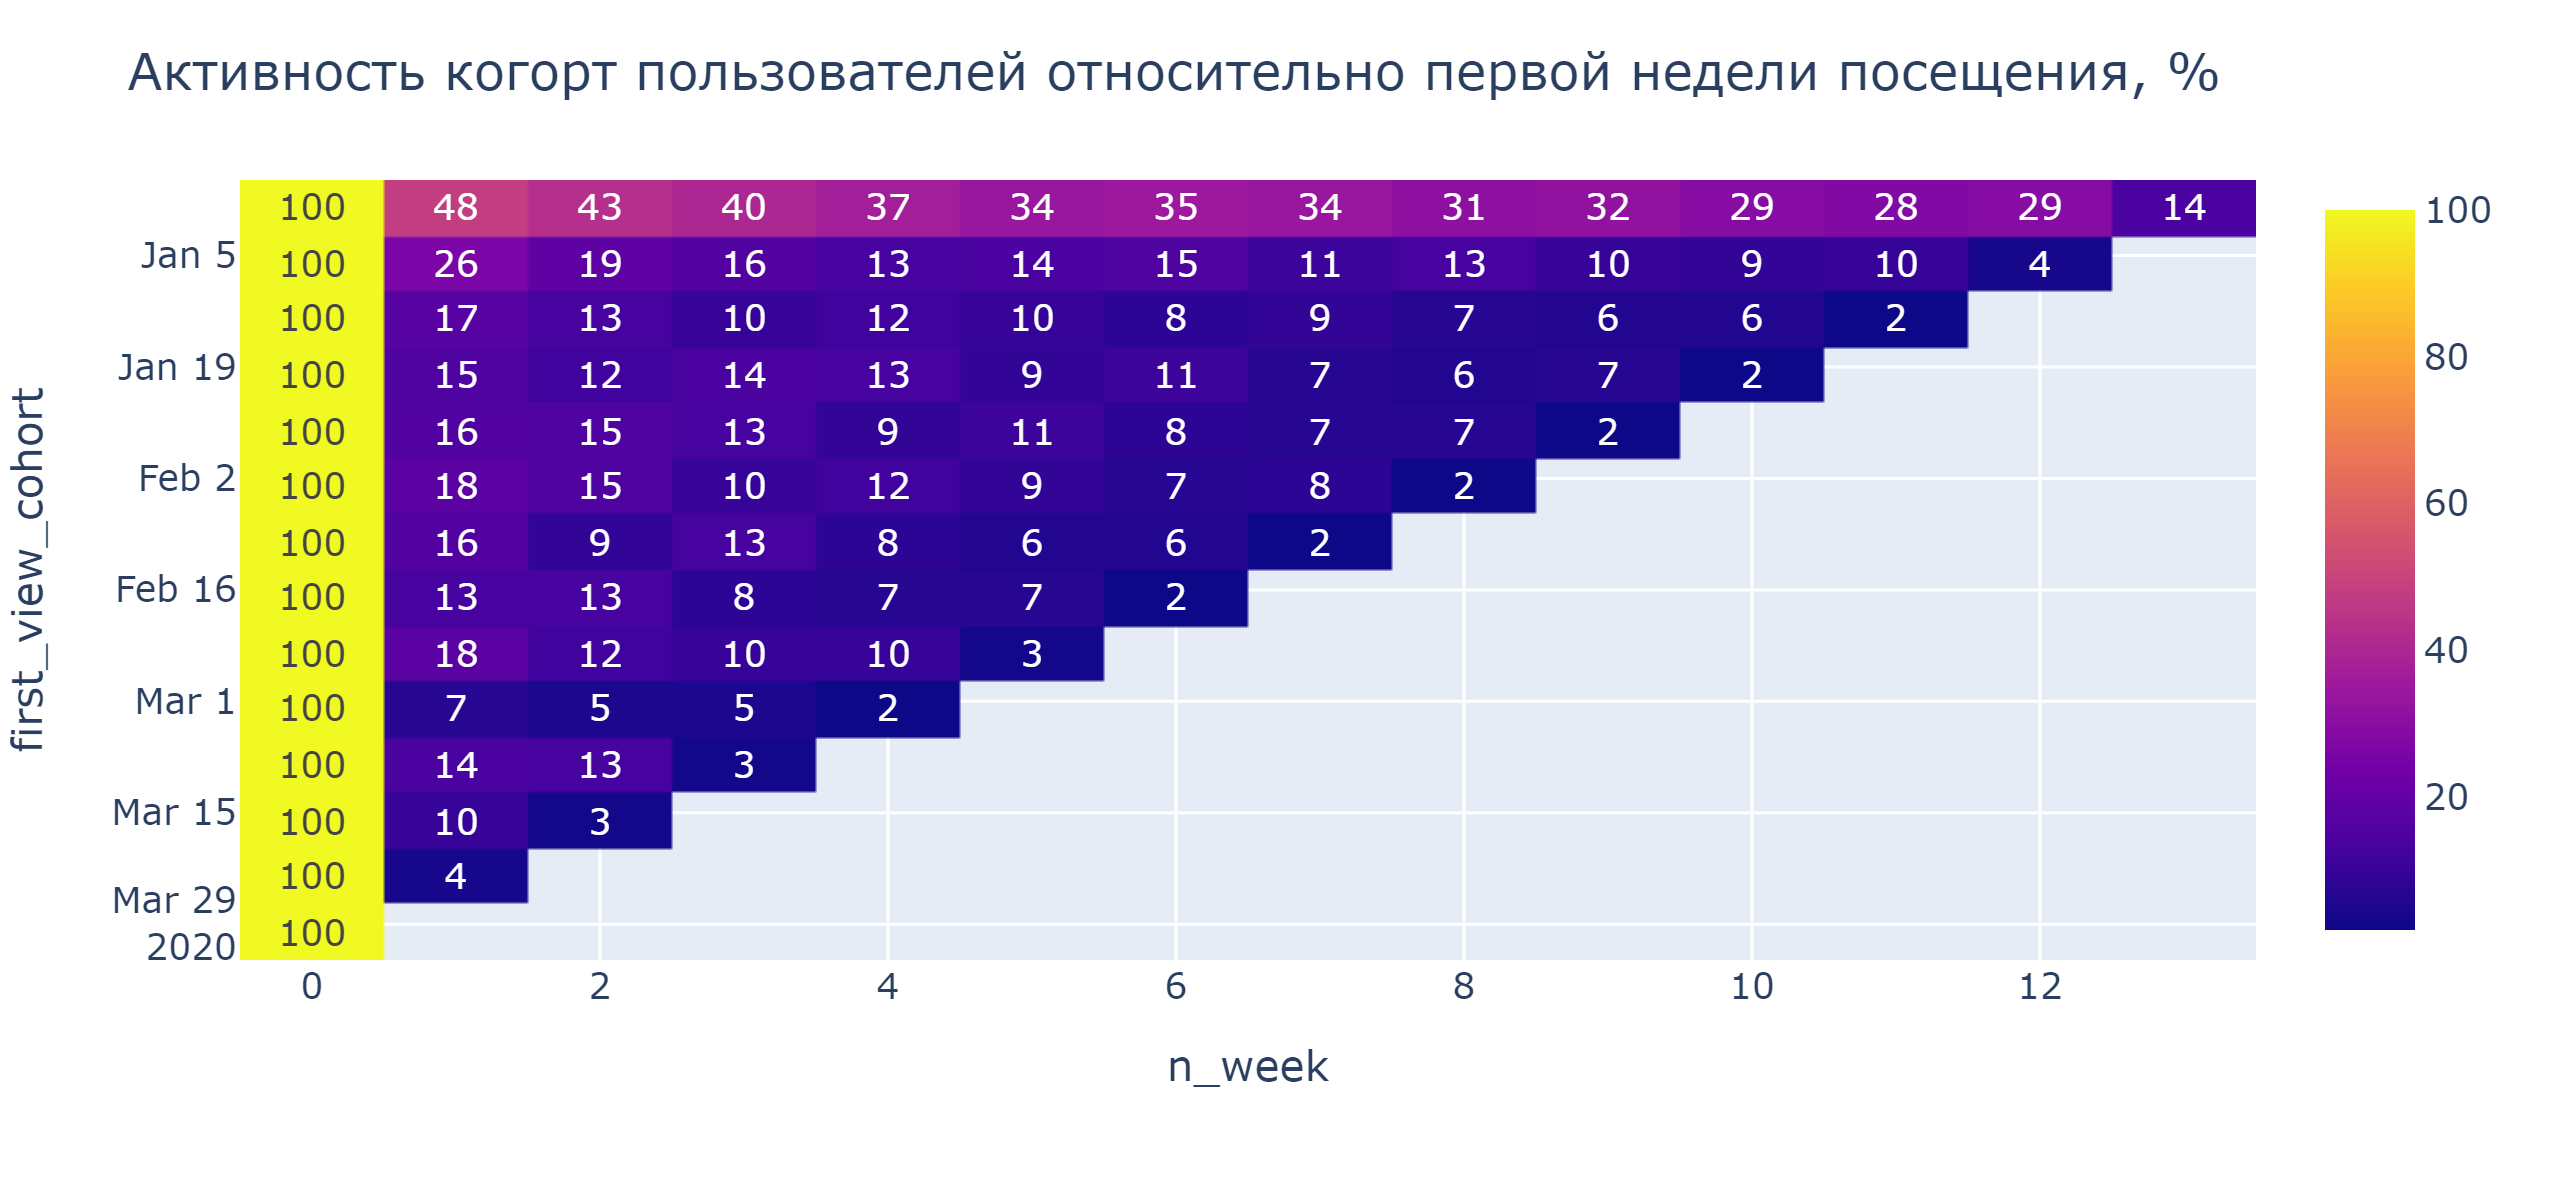

In [18]:
# создаем сводную таблицу для визуализации доли пользователей в когортах отосительно недели первого посещения
viz = viz_pivot.apply(
    lambda x: round(x*100/viz_pivot[0], 0)
)

fig = px.imshow(
    viz, 
    text_auto=True
)
fig.update_layout(
    title='Активность когорт пользователей относительно первой недели посещения, %')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Самой активной когортой по первому посещению является когорта первой недели Q1 - 30.12.2019 г. Данная когорта сохраняет активность на протяжении 13 недель.

Необходимо детально проанализировать, чем условия для данной когорты отличаются от условий для остальных когорт. Возможно мы сможем приблизить показатели остальных когорт к данной когорте.

In [19]:
# создаем DF с данными о датах первых покупок пользователей
first_purchase = data[data['event'] == 'purchase'].sort_values(
    'date'
    ).drop_duplicates(
        'device_id'
        )
# добавляем дату первой покупки в основной DF
data['first_purchase'] = data['device_id'].map(
    first_purchase.set_index(
        'device_id'
        )['date']
    )
# определяем тип данных столбца даты первой покупки
data['first_purchase'] = pd.to_datetime(
    data['first_purchase'], 
    format='%Y-%m-%d'
)
# оставляем в DF данные только о пользователях, которые совершили покупку
df = data[~data['first_purchase'].isna()].copy()
# определяем даты когорт первой покупки
df['first_purchase_cohort'] = df['first_purchase'].apply(
    lambda x: x + dt.timedelta(days=-x.weekday(), 
                               weeks=0)
)
# определяем тип данных столбца когорты первой покупки
df['date'] = pd.to_datetime(
    df['date'], 
    format = '%Y-%m-%d'
)
# создаем доп.столбец с количеством недель между неделей первой покупки и датой события
df['n_week'] = df['date'] - df['first_purchase_cohort']
df['n_week'] = df['n_week'].apply(
    lambda x: x.days // 7
)
# меняем тип данных столбца с когортой недели первой покупке на str для визуализации
df['first_purchase_cohort'] = df['first_purchase_cohort'].apply(
    lambda x: str(x)[:10]
)
# выводим суммы покупок пользователей в разрезе когорт первой покупки
df = df[df['event'] == 'purchase']
df.groupby(
    'first_purchase_cohort'
    )['purchase_sum'].sum().reset_index(
        name = 'LTV'
        ).sort_values(
            'LTV', 
            ascending = False)

first_purchase_cohort         LTV
1             2020-01-06  19787838.0
2             2020-01-13  18852452.0
0             2019-12-30  12320177.5
3             2020-01-20   9018049.5
4             2020-01-27   7432634.0
6             2020-02-10   6766314.0
5             2020-02-03   6305237.0
7             2020-02-17   5398837.5
9             2020-03-02   3629773.0
8             2020-02-24   3067633.5
12            2020-03-23   2895260.0
10            2020-03-09   2099374.5
11            2020-03-16   2099173.0
13            2020-03-30    584207.0

Разделение пользователей на когорты по первой покупке показывает, что самыми прибыльными являются первые когорты 6 и 13 января. Показатели их LTV значительно выше остальных когорт.

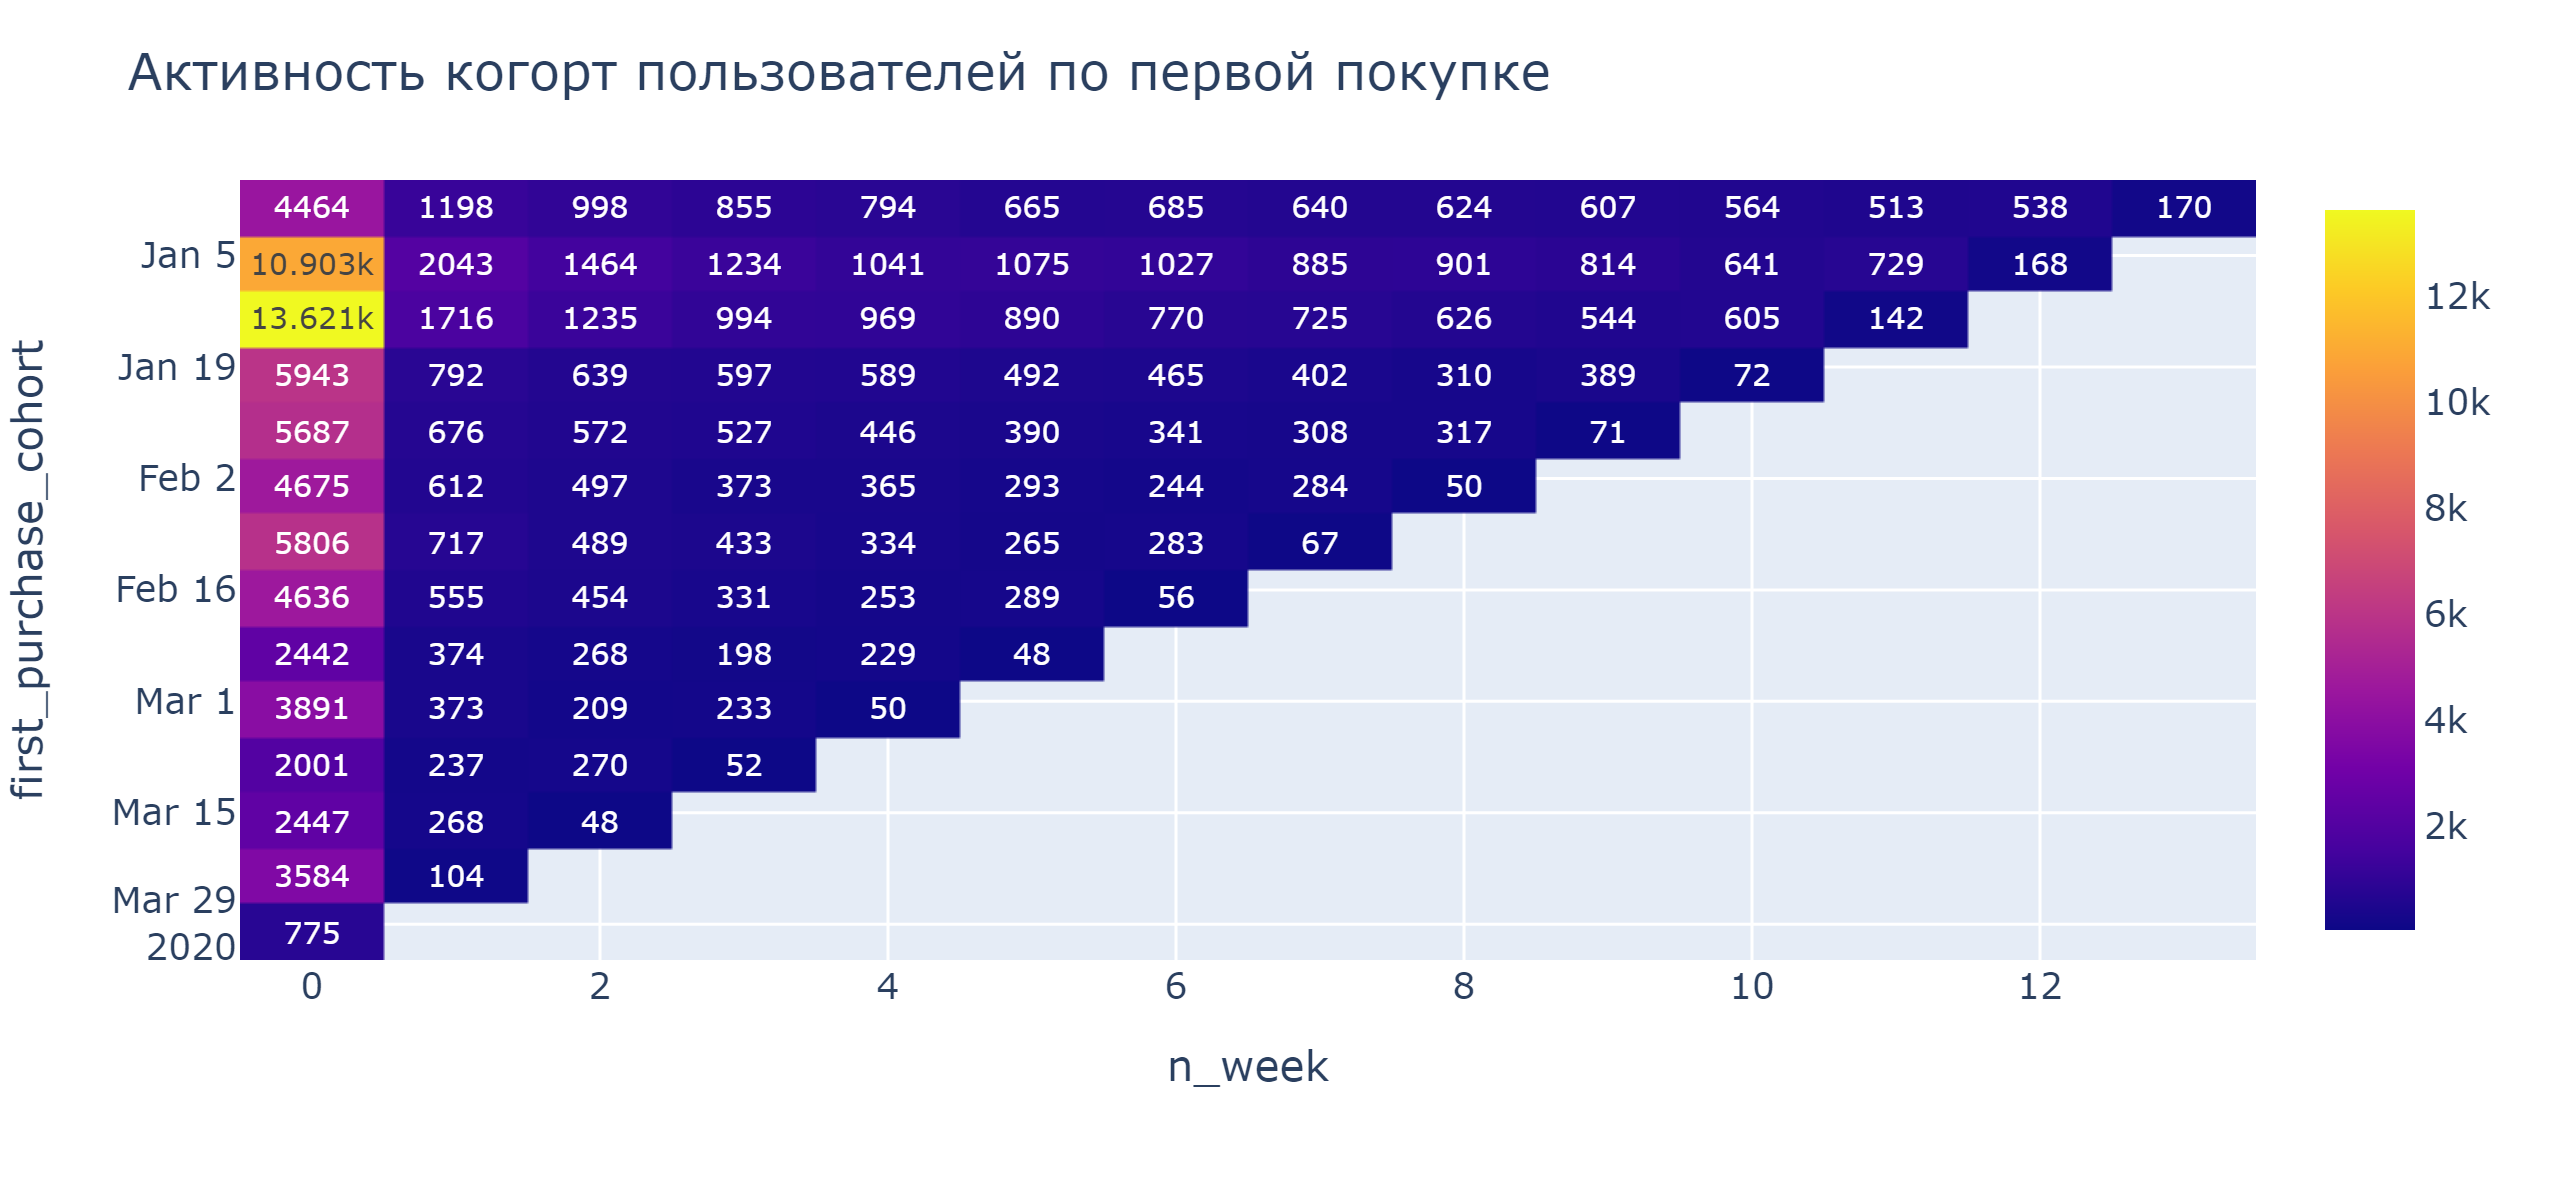

In [20]:
# создаем сводную таблицу с количеством пользователей в разрезе когорт недели первой покупки
viz_pivot = df.pivot_table(
    index='first_purchase_cohort', 
    columns='n_week', 
    values='device_id', 
    aggfunc=pd.Series.nunique
)
# создаем визуализацию количества пользователей с разрезе когорт недели первой покупки
fig = px.imshow(
    viz_pivot, 
    text_auto=True
)
fig.update_layout(
    title='Активность когорт пользователей по первой покупке')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Самыми большими когортами также являются когорты 06.01.2020 г и 13.01.2020 г.

Самой маленькой когортой являются когорта 30.03.2020 г.

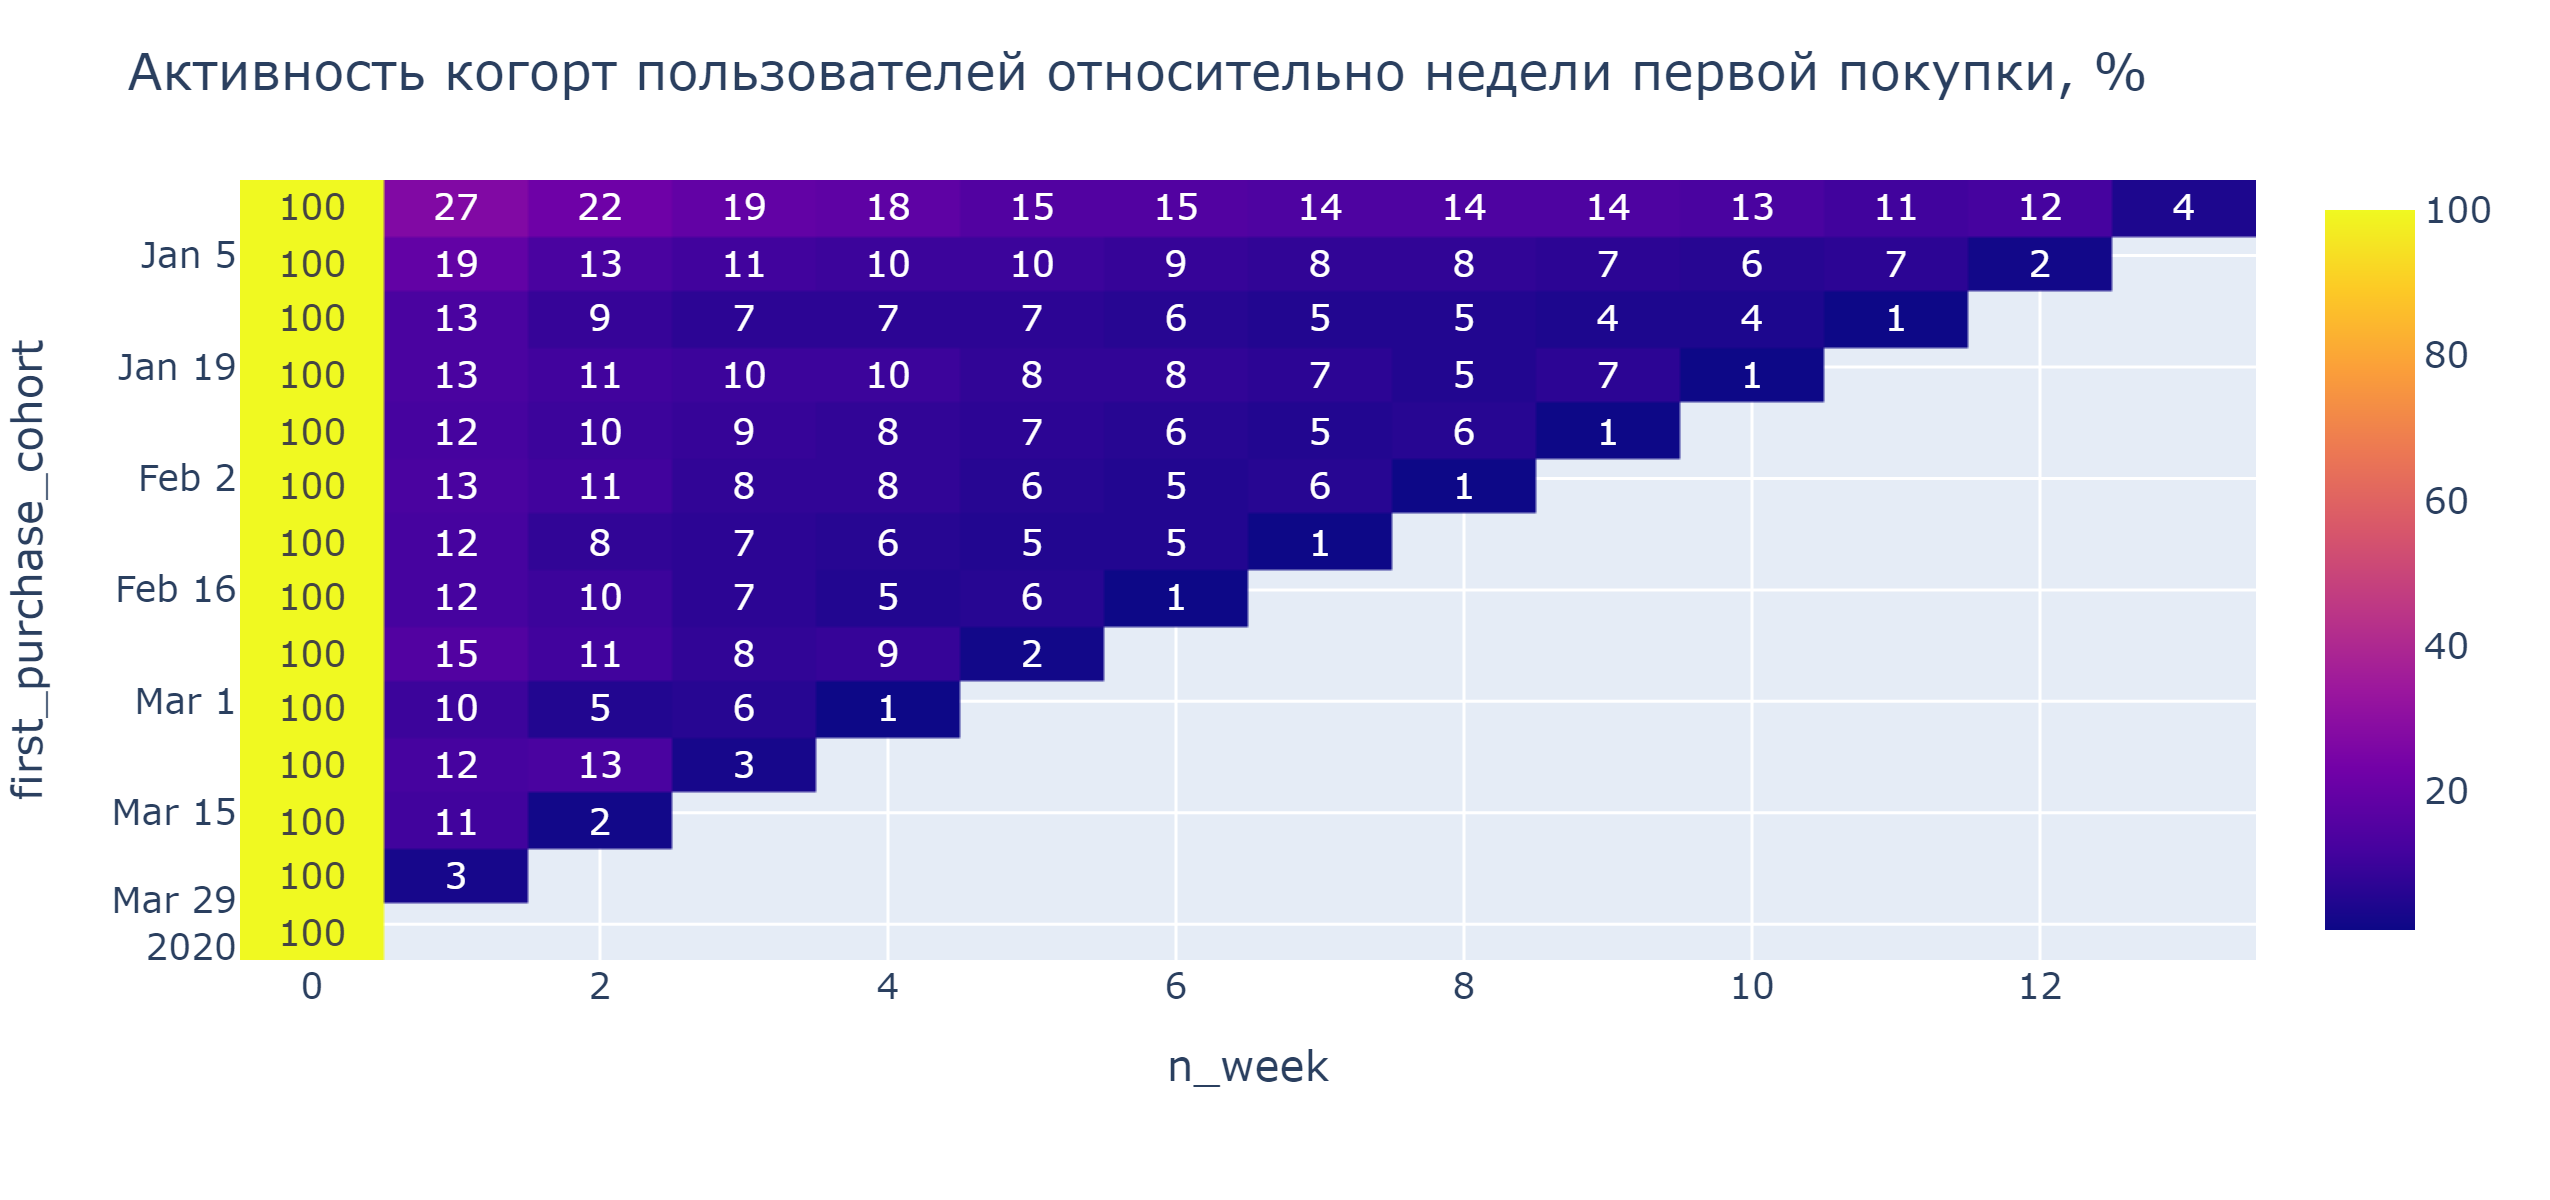

In [21]:
# создаем визуализацию доли пользователей относительно недели первой покупки
viz = viz_pivot.apply(
    lambda x: round(x*100/viz_pivot[0], 0)
)

fig = px.imshow(
    viz, 
    text_auto=True
)
fig.update_layout(
    title='Активность когорт пользователей относительно недели первой покупки, %')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Самой активной когортой также является когорта первой недели Q1.

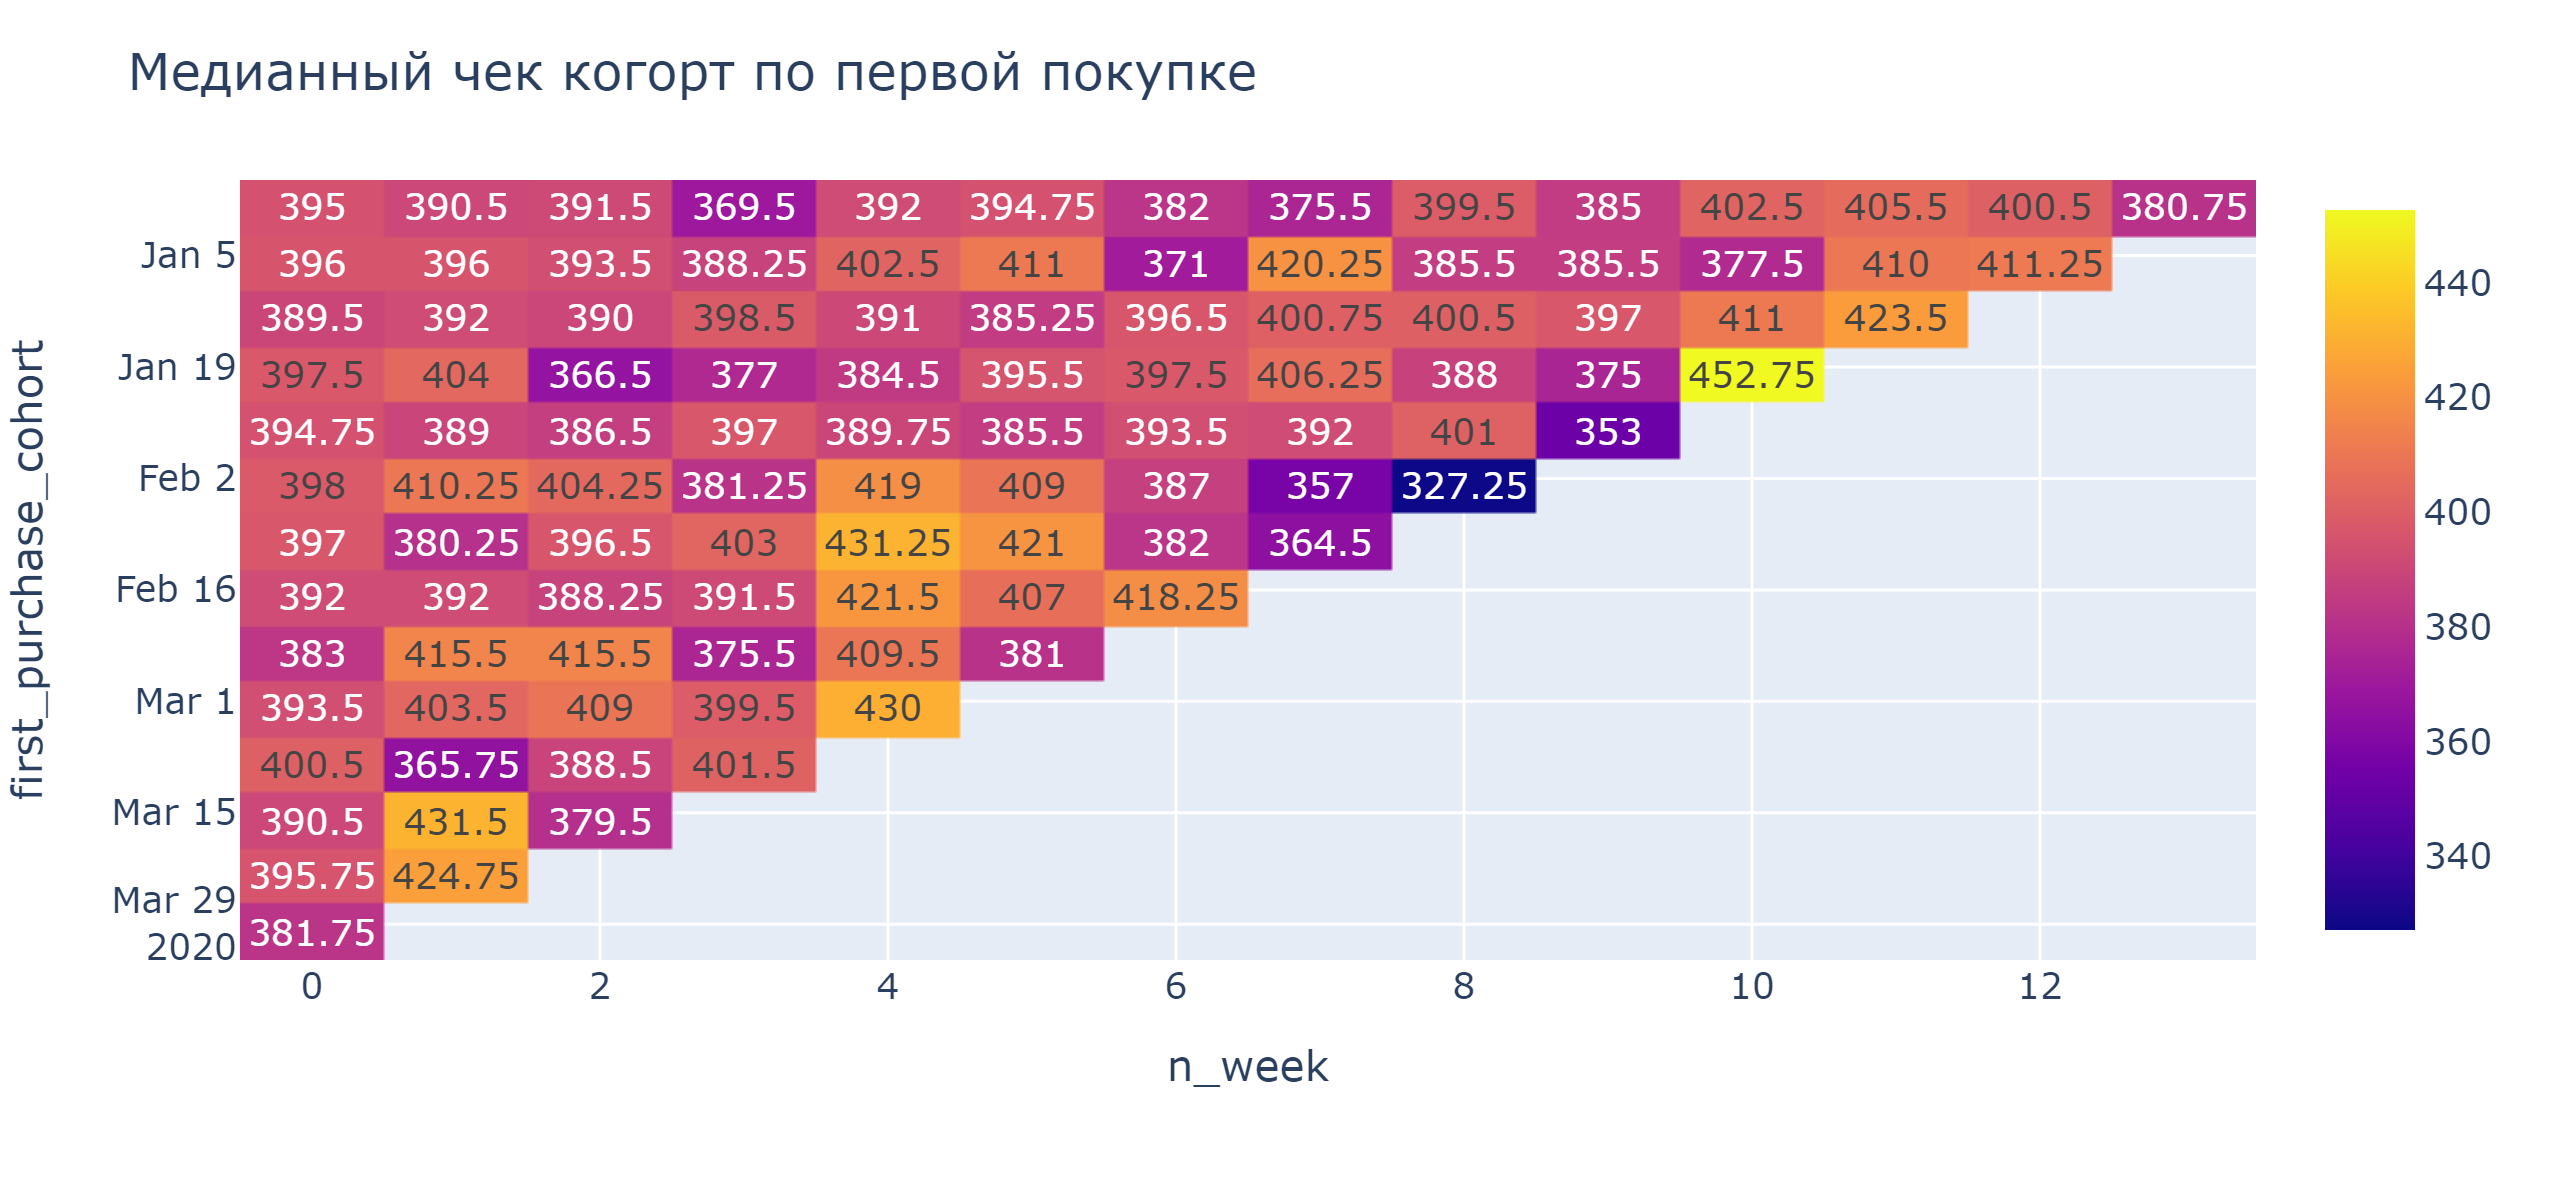

In [22]:
# создаем сводную таблицу с медианой суммой покупки пользователей в разрезе когорты недели первой покупки
viz = df.pivot_table(
    index='first_purchase_cohort', 
    columns='n_week', 
    values='purchase_sum', 
    aggfunc=np.median
)

fig = px.imshow(
    viz, 
    text_auto=True
)
fig.update_layout(
    title='Медианный чек когорт по первой покупке')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Медианный чек на неделе первой покупки выше у когорты от 9 марта (=400 рублей).

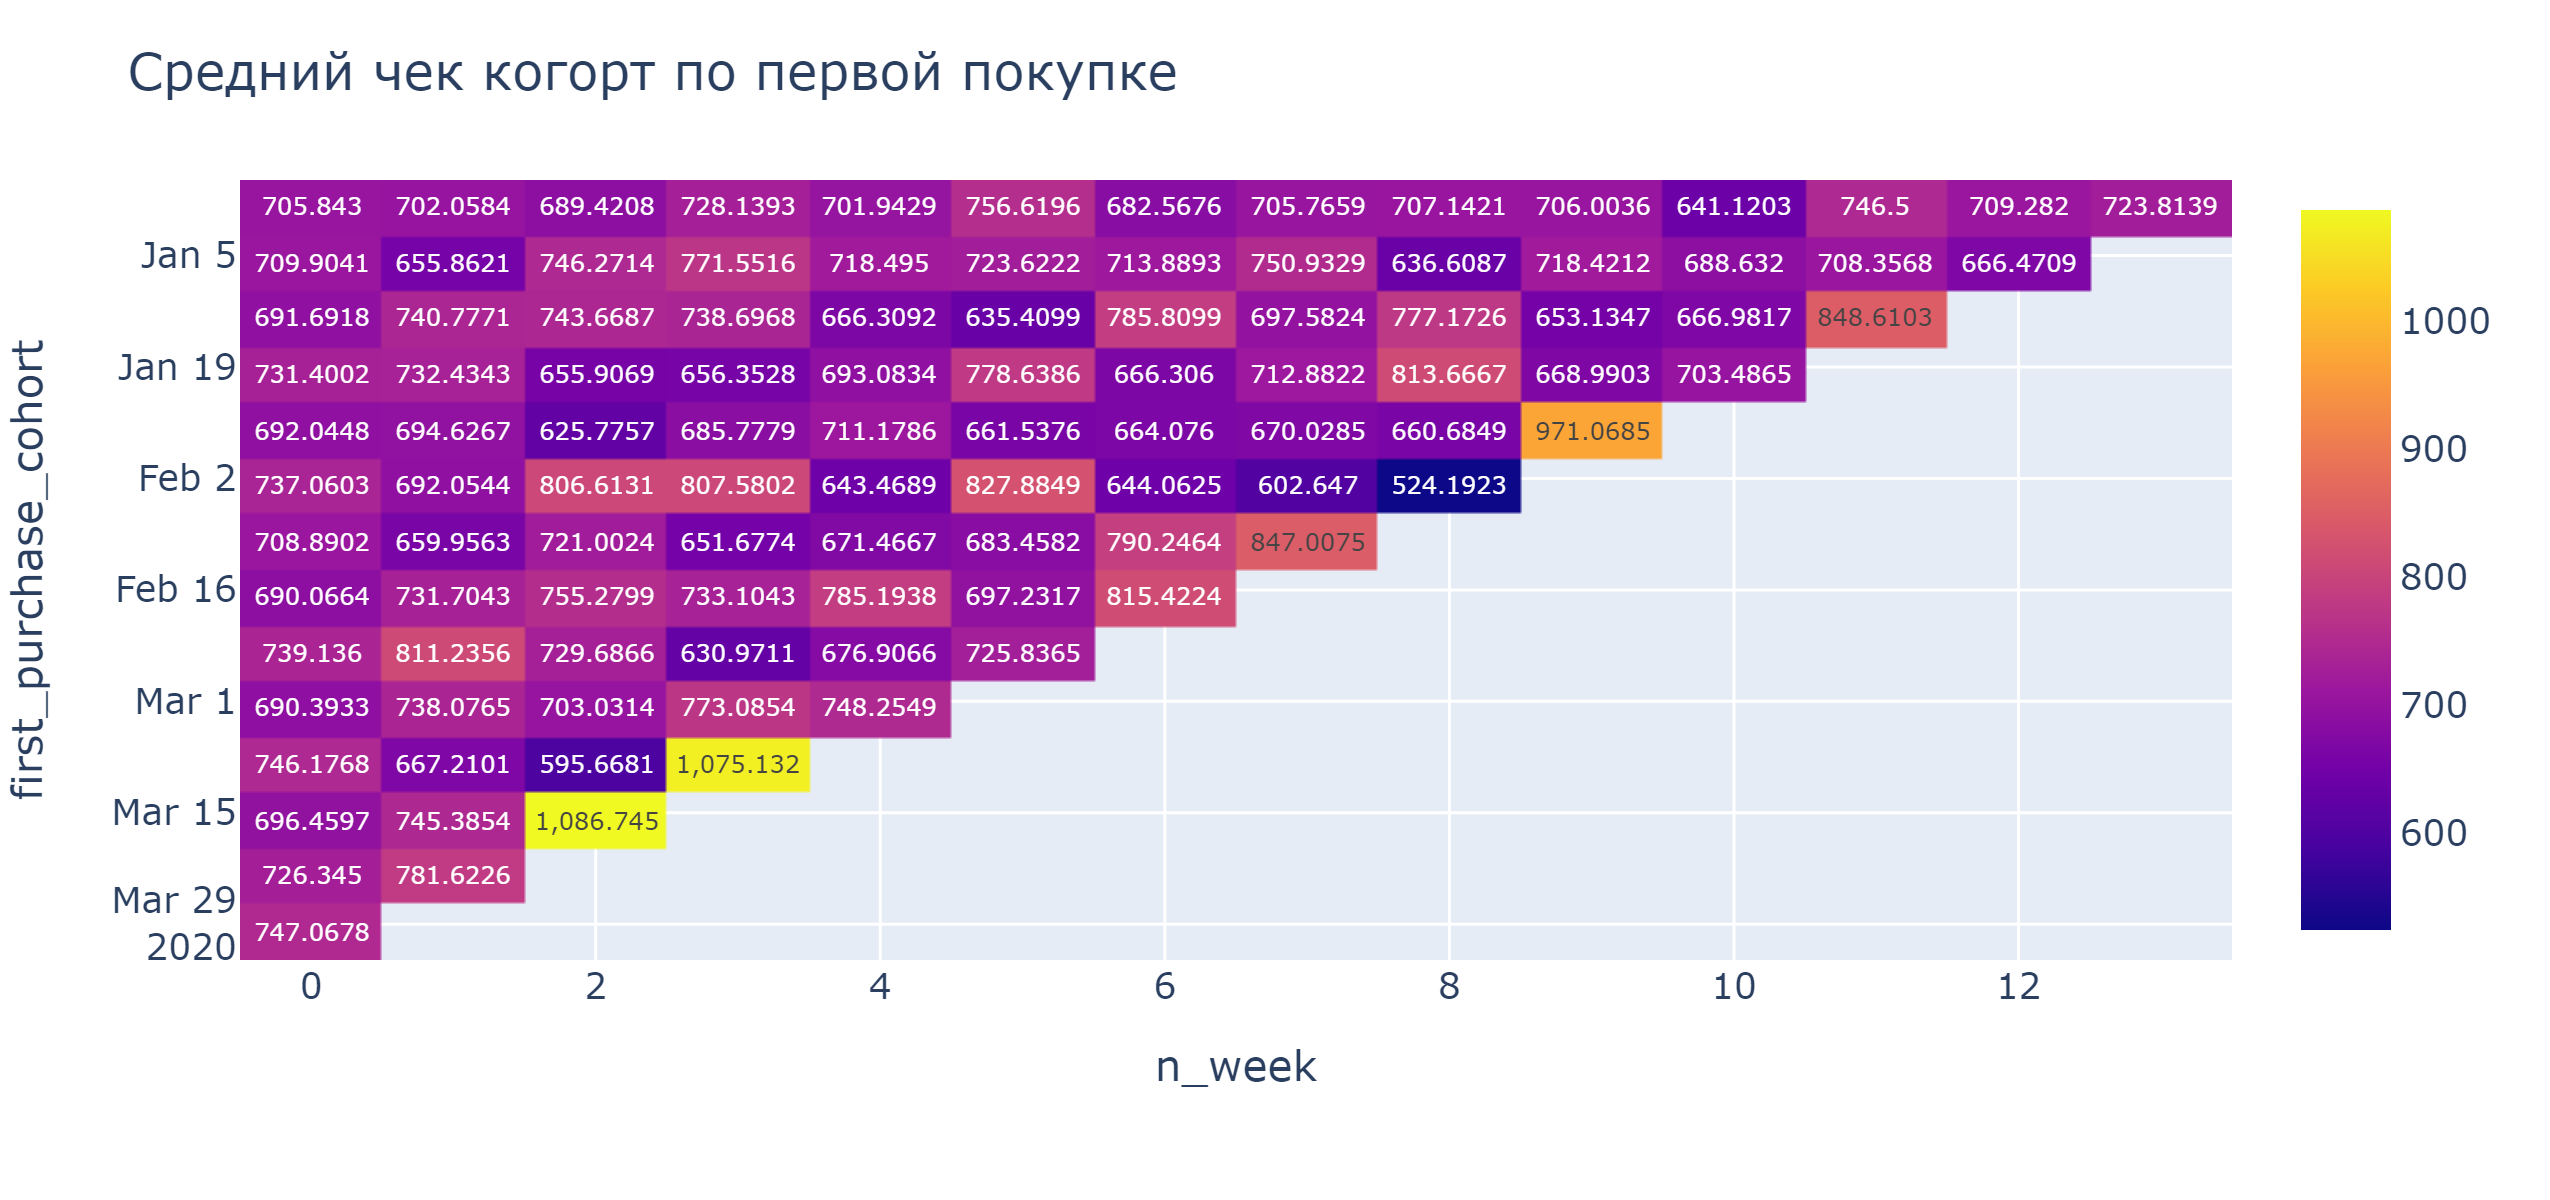

In [23]:
# создаем сводную таблицу со средней суммой покупки пользователей в разрезе когорты недели первой покупки
viz = df.pivot_table(
    index='first_purchase_cohort', 
    columns='n_week', 
    values='purchase_sum', 
    aggfunc=np.mean
)

fig = px.imshow(
    viz, 
    text_auto=True
)
fig.update_layout(
    title='Средний чек когорт по первой покупке')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

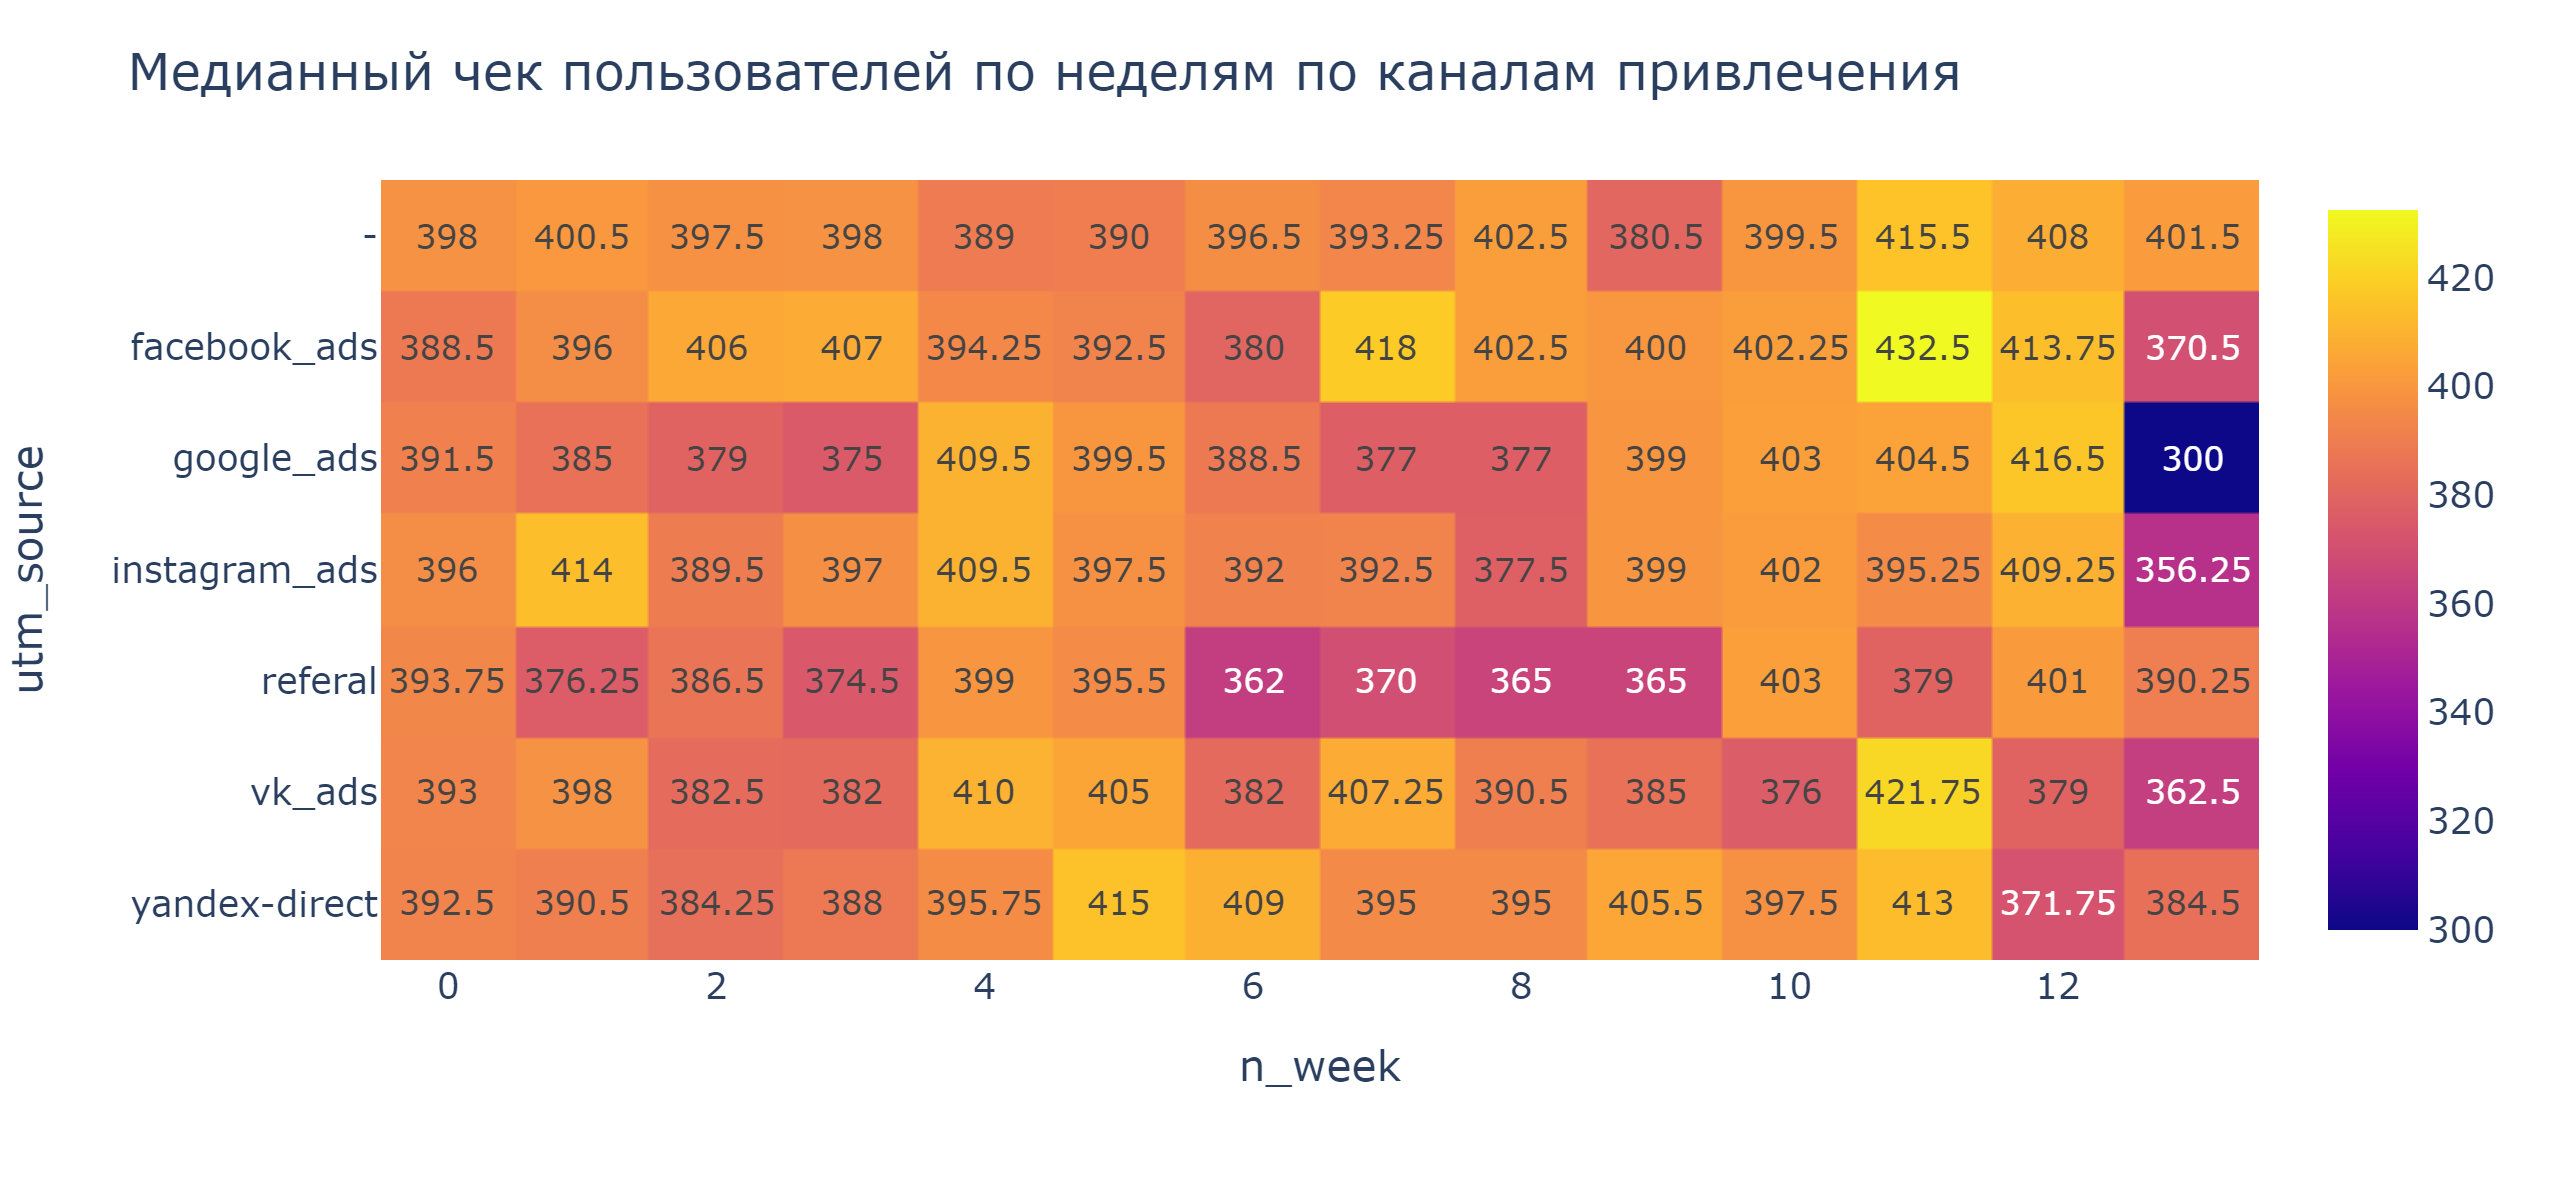

In [24]:
# создаем сводную таблицу с данными о суммах покупок пользователей в разрезе каналов привлечения
viz = df.pivot_table(
    index='utm_source', 
    columns='n_week', 
    values='purchase_sum', 
    aggfunc=np.median
)

fig = px.imshow(
    viz, 
    text_auto=True
)
fig.update_layout(
    title='Медианный чек пользователей по неделям по каналам привлечения')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Наибольший медианный чек 396 р. у пользователей пришедшим по рекламе в Инстаграм

## Выводы:

Когортный анализ по первому посещению и первой покупке показывает следующее:

1. Наибольшую активность проявляет когорта первой недели Q1 - когорта от 30.12.2019 г по первому посещению. Самые большие когорты - от 06.01.2020 г и от 13.01.20220 г. по первой покупке. Именно эти когорты приносят наибольшую выручку компании. Пользователи, которые относятся к этим когортам, остаются лояльными до 13 недель и их LTV выше, чем у остальных когорт. Необходимо детально проанализировать, чем условия для данных когорт отличаются от условий для остальных когорт. Возможно мы сможем приблизить показатели LTV остальных когорт к данным когортам.

2. Присутствует тенденция снижения активности во всех когортах.

3. Нельзя однозначно сказать, что медианный/средний чеки уменьшаются, или что пользователи пришедшие с разных каналов привлечения тратят больше/меньше. Возможно стоит рассмотреть варианты увеличения медианного/среднего чеков за счет маркетинговых акций.

Таким образом, на основе вышесказанного, компании стоит рассмотреть варианты повышения лояльности старых клиентов и упростить процесс регистрации для новых клиентов.